 This notebook uses conda/analysis2-23.07

 See info here: 
 https://climate-cms.org/cms-wiki/services/services-conda.html


# Preamble

In [1]:
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
matplotlib.rcParams['pdf.fonttype'] = 42
from datetime import datetime
import scipy.special
import xarray as xr
import iris
import glob as gb
from matplotlib.lines import Line2D
import dask

In [2]:
from dask.distributed import Client,LocalCluster
client = Client()

In [3]:
client

<Client: 'tcp://127.0.0.1:44973' processes=7 threads=7, memory=32.00 GiB>

In [4]:
obs_names = ['CAPRICORN1','CAPRICORN2','MARCUS','CAMMPCAN','Ice2Equator','Cold Water Trial','PCAN',
             'Kennaook-Cape Grim','Macquarie Island','Syowa']#,'Kennaook-Cape Grim offset'] 
cols = ['steelblue','darkkhaki','indianred','maroon','goldenrod','forestgreen','navy','cadetblue','black']
style = ['-','-','--','--',':',':',':','-.','-']
run = ['Control','Control*','BL NPF','OM2','PMO','H22','PMO+H22','SSA Gust','Obs'] 
jobs = ['dg657','bx400','cg283','ch543','cq687','cq686','dd153','dd154']


In [5]:
fig_dir = '/home/563/slf563/shared_code/2024/ACCESS_aerosol_eval/'

# Organise data 

In [6]:
def read_obs(name):
    f_path = '/g/data/jk72/slf563/OBS/campaigns/cleaned_SO_campaign_data/'
    data = pd.read_csv(f_path+'aerosol - {} - daily means from hrly data.csv'.format(name),index_col=0)
    data.index = pd.DatetimeIndex(data.index)
    data.index = data.index.rename('time')

    # Make all CN names the same - will make dummy if does not exist 
    if 'cn10_avg' not in data.keys():
        if 'cn_avg' in data.keys():
            data = data.rename(columns={'cn_avg':'cn10_avg'})
        elif 'CN10' in data.keys():
            data = data.rename(columns={'CN10':'cn10_avg'})
        else: 
            data['cn10_avg'] = np.nan  

    # Make all CCN names the same - will make dummy if does not exist 
    if 'ccn_avg' not in data.keys():
        if 'ccn_0.5504_avg' in data.keys():
            data = data.rename(columns={'ccn_0.5504_avg':'ccn_avg'})
        elif 'ccn_0.5_avg' in data.keys():
            data = data.rename(columns={'ccn_0.5_avg':'ccn_avg'})
        elif 'ccn_0.55_avg' in data.keys():
            data = data.rename(columns={'ccn_0.55_avg':'ccn_avg'})
        elif 'ccn_0.55_avg' in data.keys():
            data = data.rename(columns={'ccn_0.55_avg':'ccn_avg'})
        elif 'ccn_n' in data.keys():
            data = data.rename(columns={'CCN_Count':'ccn_avg'}) # THIS IS FOR KCG
        else:    
            data['ccn_avg'] = np.nan

    return data

In [7]:
def read_model_data(run,voyage,field): 
    
    fdir = '/g/data/jk72/slf563/ACCESS/output/campaign_data/'
    if os.path.exists(fdir+'{}_daily_mean_{}_vars.nc'.format(run,voyage)): 
        data = xr.open_dataset(fdir+'{}_daily_mean_{}_vars.nc'.format(run,voyage))
        
        data = data[[field,'lat','lon']].assign_coords(model=run)
        if 'z1_hybrid_height' in list(data.coords): 
            data = data.isel(z1_hybrid_height=0)
        data = data.sortby('time')
        
        if voyage == 'Ice2Equator': # limit to south of NZ as per Humphries et al. 2023
            data = data.where(data.lat<-47.5)
                
    else: print('no data')
    return(data)

In [8]:
 def organise_model_data(voyage,feild):
    fld0 = read_model_data('dg657',voyage,feild).set_coords(['lat','lon']) 
    fld1 = read_model_data('bx400',voyage,feild).set_coords(['lat','lon'])
    fld2 = read_model_data('cg283',voyage,feild).set_coords(['lat','lon'])
    fld3 = read_model_data('ch543',voyage,feild).set_coords(['lat','lon'])
    fld4 = read_model_data('cq686',voyage,feild).set_coords(['lat','lon'])
    fld5 = read_model_data('cq687',voyage,feild).set_coords(['lat','lon'])
    fld6 = read_model_data('dd153',voyage,feild).set_coords(['lat','lon'])
    fld7 = read_model_data('dd154',voyage,feild).set_coords(['lat','lon'])
    feild = xr.concat([fld0,fld1,fld2,fld3,fld4,fld5,fld6,fld7],dim='model')
    feild['model'] = run[:-1] 
    return feild

In [9]:
def combine_model_obs(obsname,field,sim='Control',removenans='yes'):
    if field == 'N10': 
        obsf = 'cn10_avg'
    elif field == 'CCN40': 
        obsf = 'ccn_avg'    
    else: 
        obsf = 'None'
    data = organise_model_data(obsname,field)

    obs = read_obs(obsname)
    if sim != 'all': 
        data = data.loc[{'model':sim}]
        data = data.to_pandas()
        data['Obs'] = 0
        if obsf != 'None':
            data['Obs'][:] = obs[obsf].loc[data.index[0].date():data.index[-1].date()]
        
    else: 
        data = data[field].T.to_pandas()
        if obsname not in ['Macquarie Island','Kennaook-Cape Grim','Syowa','Kennaook-Cape Grim offset']: 
            if obsf != 'None': 
                obs = obs[[obsf,'lat','lon']]
            else: 
                obs = obs[['lat','lon']]
            data[['Obs','lat','lon']] = np.nan
            if obsf != 'None':
                data['Obs'][:] = obs[obsf].loc[data.index[0].date():data.index[-1].date()]
            data['lat'][:] = obs['lat'].loc[data.index[0].date():data.index[-1].date()]
            data['lon'][:] = obs['lon'].loc[data.index[0].date():data.index[-1].date()]
        else: 
            data['Obs'] = 0
            if obsf != 'None':
                data['Obs'][:] = obs[obsf].loc[data.index[0].date():data.index[-1].date()]
            
    if (removenans=='yes') and (obsf != 'None'):   
        data[np.isnan(data.Obs)] = np.nan
        
    return data

In [10]:
def combine_voyage_data(obs,field): 
    for v,vn in enumerate(obs):
        f1 = combine_model_obs(vn,field,sim='all')
        f1 = f1.to_xarray()
        f1 = f1.assign_coords({'Voyage':vn})
        f1 = f1.expand_dims('Voyage')
        if v == 0: 
            f_all = f1
        else: 
            f_all = xr.concat([f_all,f1],dim='Voyage')

    return(f_all)

In [11]:
def get_spatial_data(): 
    print('takes a moment')
    for i,job in enumerate(jobs): 
        data = xr.open_mfdataset('/g/data/jk72/slf563/ACCESS/output/campaign_data/{}_spatial_fields*'.format(job),parallel=True)
        data = data.assign_coords({'run':run[i]})
        data = data.expand_dims('run')
        data1 = data.mean('time') 
        data2 = data.groupby('time.season').mean()
        del(data) 
        if job == 'dg657': 
            data_ann = data1
            data_sea = data2
        else: 
            data_ann = data_ann.merge(data1)
            data_sea = data_sea.merge(data2)
        del(data1)
        del(data2)

    obs = xr.open_dataset('/g/data/jk72/slf563/ACCESS/ML_data/COSP_vars_MODIS_2015-2019.nc')
    obssea = obs.groupby('time.season').mean()
    obsann = obs.mean('time') 
    del(obs)

    return(data_ann,data_sea,obsann,obssea)

# Plotting functions 

In [12]:
def plot_station_monthly(data,field):

    if field == 'N10': 
        obsf = 'cn10_avg'
    if field == 'CCN40': 
        obsf = 'ccn_avg'  

    data = data.to_xarray()
    data_med = data.groupby('time.month').median()
    data_25 = data.groupby('time.month').quantile(0.25)
    data_75 = data.groupby('time.month').quantile(0.75)
    
    for i,r in enumerate(run):
        if (r == 'Obs') or (r == 'Control'): 
            ax.fill_between(data_med.month, data_25[r].values, data_75[r].values, facecolor=cols[i],alpha=0.1)
        plt.plot(data_med.month, data_med[r].values, color=cols[i], label=r,linewidth=1.5,linestyle=style[i])

        if np.isnan(data_25[r].mean())==False: 
            if  (r == 'Obs') or (r == 'Control'): 
                ax.fill_between([12.4+(i*0.1),12.9+(i*0.1)], data[r].quantile(0.25), data[r].quantile(0.75), 
                            facecolor=cols[i],alpha=0.1)
        
            plt.plot([12.4+(i*0.1),12.9+(i*0.1)],[data[r].median(),data[r].median()],color=cols[i],linewidth=1.5,linestyle=style[i])
    
    plt.xlabel('Month')
    if field == 'N10': 
        plt.ylabel('N10 (cm$^{-3}$)')
        #plt.yscale('log')
    elif field == 'CCN40':
        plt.ylabel('CCN (cm$^{-3}$)')
    elif field == 'CCN/N10':
        plt.ylabel('CCN/N10')
        
    plt.xlim(0.7,13.9)
    plt.rcParams.update({'font.size': 12})
    #plt.legend(ncols=3,loc='upper left')
    plt.text(x = 0.88, y = 0.95, s = 'Annual',transform=ax.transAxes)
    plt.axvline(12.25,color='black',linewidth=0.5)
    #print(data_med.to_dataframe())

In [13]:
def get_counts(fc): 
    count = np.zeros(4)
    seasons = ['DJF','MAM','JJA','SON']
    for s in fc.Control.season.values:
        i = seasons.index(s)
        count[i] = fc.Control.loc[s]
        #print(fc.Control.loc[s].values)
    count = count.astype(int)
    return count

In [14]:
def plot_by_sea_lat(f,obsname,legend='no'):

    fm = f.groupby('time.season').median(dim=['time','Voyage'])
    fc = f.groupby('time.season').count(dim=['time','Voyage'])
    counts = get_counts(fc)
    f25 = f.groupby('time.season').quantile(0.25,dim=['time','Voyage'])
    f75 = f.groupby('time.season').quantile(0.75,dim=['time','Voyage'])
    for m,sim in enumerate(run):
        for s,sea in enumerate(['DJF','MAM','JJA','SON']):
            if sea in fm.season:
                if fm[sim].loc[sea].notnull():
                    if legend=='yes' and s == 0 : 
                        plt.plot([0.65+(m*0.05)+s,1.15+(m*0.05)+s],[fm[sim].loc[sea],fm[sim].loc[sea]],color=cols[m],label=sim,linestyle=style[m],linewidth=1.5)
                        plt.legend(ncol=9,bbox_to_anchor=(1,-0.2))
                    else: 
                        plt.plot([0.65+(m*0.05)+s,1.15+(m*0.05)+s],[fm[sim].loc[sea],fm[sim].loc[sea]],color=cols[m],linestyle=style[m],linewidth=1.5)
                    if (sim == 'Obs') or (sim == 'Control'): 
                        ax.fill_between([0.65+(m*0.05)+s,1.15+(m*0.05)+s], f25[sim].loc[sea], 
                                        f75[sim].loc[sea], facecolor=cols[m],alpha=0.1)
    ax.set_xticklabels(['DJF ({})'.format(counts[0]),'MAM ({})'.format(counts[1]),
                        'JJA ({})'.format(counts[2]),'SON ({})'.format(counts[3])]);
    plt.xticks([1,2,3,4]);

In [15]:
def plot_biases(data,label,subplot,vmin,vmax,plot_cont=np.array([False]),cmap='RdBu_r',norm='Norm',cbar=False,projection=ccrs.PlateCarree()):
    if norm == 'Norm':
        norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)
    if isinstance(subplot,int):
        ax = plt.subplot(subplot, projection=projection)
    elif isinstance(subplot,list):
        ax = plt.subplot(subplot[0],subplot[1],subplot[2], projection=projection)
    else: 
        ax = subplot 
    p = data.plot(
                cmap=cmap,
                transform=ccrs.PlateCarree(),
                ax = ax,
                norm=norm,
                add_colorbar=False,
                );
    if plot_cont.any(): 
        plot_cont.plot.contour(
                transform=ccrs.PlateCarree(),
                levels=[-200,0,200,500],
                colors='grey',linewidths=0.5,
                ax = ax,
                );
    
    ax.coastlines();
    plt.title('')
    plt.title(label,loc='left')
    
    if cbar==True: 
        plt.colorbar(p,orientation='horizontal',pad=0.05)
    return p

# Table functions 

In [16]:
def generate_station_tables(station,var,df):
    if (station=='Syowa') and (var=='CCN40'): 
        data = combine_model_obs(station,var,sim='all',removenans='no')
    else:
        data = combine_model_obs(station,var,sim='all')
    data = data.to_xarray()

    diffabs = data[run[:]] - data['Obs']
    diffrel = 100*(data[run[:]]- data['Obs'])/data['Obs']
    
    for r in run[:]:
        df['Ann'].loc[station,r,'Median'] = data.median().to_pandas()[r]
        df['Ann'].loc[station,r,'StdDev'] = data.std().to_pandas()[r]
        df['Ann'].loc[station,r,'MAE'] = diffabs.median().to_pandas()[r]
        df['Ann'].loc[station,r,'\%'] = diffrel.median().to_pandas()[r] # slash for latex
        df['Ann'].loc[station,r,'R$^2$'] = xr.corr(data['Obs'],data[r]).values
    
    diffabs = diffabs.groupby('time.season').median()
    diffrel = diffrel.groupby('time.season').median()
    datamed = data.groupby('time.season').median()
    seastd = data.groupby('time.season').std()
    
    for r in run[:]:
        df.loc[station,r,'Median'][['DJF','MAM','JJA','SON']] = datamed.to_pandas()[r]
        df.loc[station,r,'StdDev'][['DJF','MAM','JJA','SON']] = seastd.to_pandas()[r]
        df.loc[station,r,'MAE'][['DJF','MAM','JJA','SON']] = diffabs.to_pandas()[r]
        df.loc[station,r,'\%'][['DJF','MAM','JJA','SON']] = diffrel.to_pandas()[r]
        for s in ['DJF','MAM','JJA','SON']: 
            df[s].loc[station,r,'R$^2$'] = xr.corr(data['Obs'].groupby('time.season')[s],
                                                data[r].groupby('time.season')[s]).values
    
    return df 

In [17]:
def generate_voyage_tables(data,loc,df):
    if loc == '<45S': 
        data = data.where(data.lat>-45)
    elif loc == '45-60S': 
        data = data.where((data.lat<-45) & (data.lat>-60))
    elif loc == '60-65S':
        data = data.where((data.lat<-60) & (data.lat>-65))
    elif loc == '>65S': 
        data = data.where((data.lat<-65))
    else: 
        print('not a pre-defined latitude range')
        return


    diffabs = data[run] - data['Obs']
    diffrel = 100*(data[run]- data['Obs'])/data['Obs']
    
    for r in run[:]:
        df['Ann'].loc[loc,r,'Median'] = data.median(['Voyage','time']).to_pandas()[r]
        df['Ann'].loc[loc,r,'StdDev'] = data.std(['Voyage','time']).to_pandas()[r]
        df['Ann'].loc[loc,r,'MAE'] = diffabs.median(['Voyage','time']).to_pandas()[r]
        df['Ann'].loc[loc,r,'\%'] = diffrel.median(['Voyage','time']).to_pandas()[r] # slash for latex
        df['Ann'].loc[loc,r,'R$^2$'] = xr.corr(data['Obs'],data[r]).values
    
    diffabs = diffabs.groupby('time.season').median(['Voyage','time'])
    diffrel = diffrel.groupby('time.season').median(['Voyage','time'])
    datamed = data.groupby('time.season').median(['Voyage','time'])
    seastd = data.groupby('time.season').std(['Voyage','time'])
    
    for r in run[:]:
        df.loc[loc,r,'Median'][['DJF','MAM','SON']] = datamed.to_pandas()[r]
        df.loc[loc,r,'StdDev'][['DJF','MAM','SON']] = seastd.to_pandas()[r]
        df.loc[loc,r,'MAE'][['DJF','MAM','SON']] = diffabs.to_pandas()[r]
        df.loc[loc,r,'\%'][['DJF','MAM','SON']] = diffrel.to_pandas()[r]
        for s in ['DJF','MAM','SON']: 
            df[s].loc[loc,r,'R$^2$'] = xr.corr(data['Obs'].groupby('time.season')[s],
                                                data[r].groupby('time.season')[s]).values
    
    return df

# Figure 1 DMS clims

In [18]:
fname = '/g/data/jk72/slf563/ACCESS/ANCIL/DMS_Rev3_N96.nc'
H22 = xr.open_mfdataset(fname)

fname = '/g/data/jk72/slf563/ACCESS/ANCIL/DMS_conc_LANA.nc'
lana = xr.open_mfdataset(fname,decode_times=False)

fname = '/g/data/jk72/slf563/ACCESS/ACCESS-OM2/dms_access-om2_iamip2-his_*'
dmsom2 = xr.open_mfdataset(fname)
dmsom2 = dmsom2.dms.groupby('time.season').mean()

fname = '/g/data/jk72/slf563/ACCESS/ANCIL/qrclim.sulpdms'
kettle =iris.load_cube(fname)
kettle = xr.DataArray.from_iris(kettle)
kettle = kettle.rename({'latitude':'lat','longitude':'lon'})


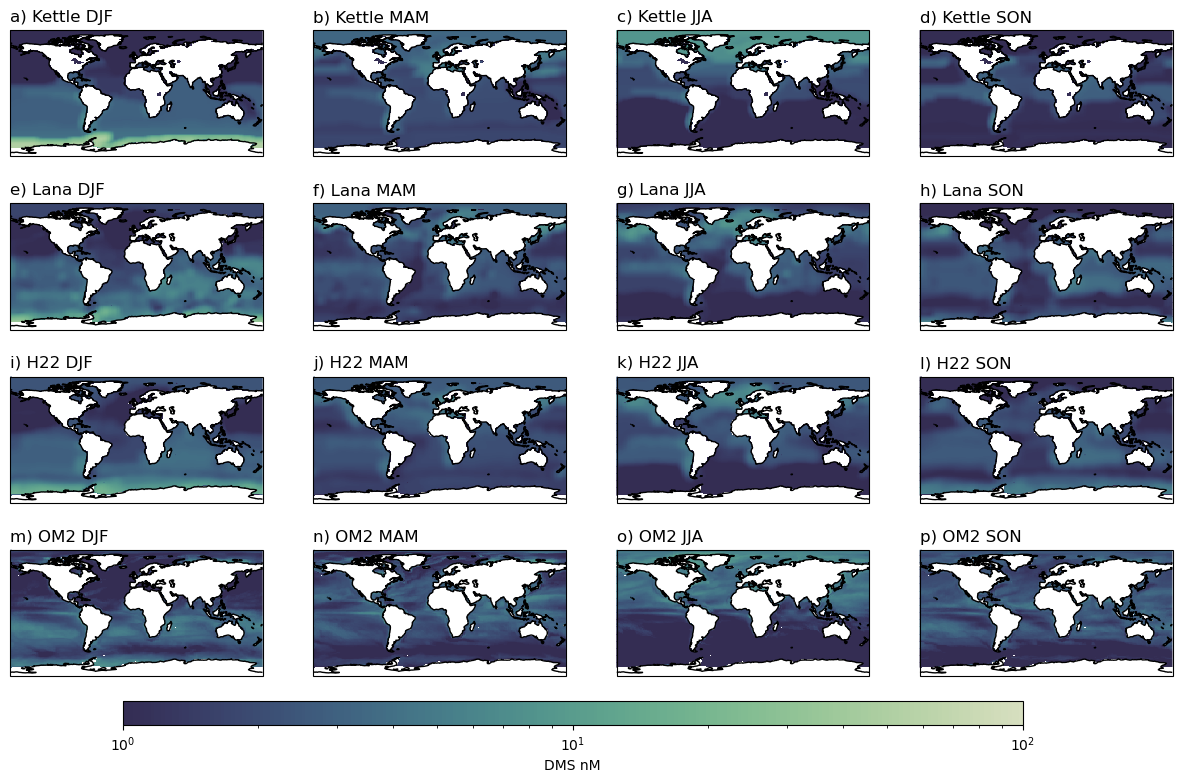

In [19]:
norm = matplotlib.colors.LogNorm(vmin=1,vmax=100)
cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True, dark=0.2)

fig = plt.figure(figsize=(15,8))

p = plot_biases(kettle[[0,1,11],:,:].mean('time'),'a) Kettle DJF',441,0,20,cmap=cmap,norm=norm)
p = plot_biases(kettle[2:5,:,:].mean('time'),'b) Kettle MAM',442,0,20,cmap=cmap,norm=norm)
p = plot_biases(kettle[5:8,:,:].mean('time'),'c) Kettle JJA',443,0,20,cmap=cmap,norm=norm)
p = plot_biases(kettle[8:11,:,:].mean('time'),'d) Kettle SON',444,0,20,cmap=cmap,norm=norm)

p = plot_biases(lana['field575'][[0,1,11],0,:,:].mean('t'),'e) Lana DJF',445,0,20,cmap=cmap,norm=norm)
p = plot_biases(lana['field575'][2:5,0,:,:].mean('t'),'f) Lana MAM',446,0,20,cmap=cmap,norm=norm)
p = plot_biases(lana['field575'][5:8,0,:,:].mean('t'),'g) Lana JJA',447,0,20,cmap=cmap,norm=norm)
p = plot_biases(lana['field575'][8:11,0,:,:].mean('t'),'h) Lana SON',448,0,20,cmap=cmap,norm=norm)

p = plot_biases(H22['dms'][[0,1,11],:,:].mean('time'),'i) H22 DJF',449,0,20,cmap=cmap,norm=norm)
p = plot_biases(H22['dms'][2:5,:,:].mean('time'),'j) H22 MAM',[4,4,10],0,20,cmap=cmap,norm=norm)
p = plot_biases(H22['dms'][5:8,:,:].mean('time'),'k) H22 JJA',[4,4,11],0,20,cmap=cmap,norm=norm)
p = plot_biases(H22['dms'][8:11,:,:].mean('time'),'l) H22 SON',[4,4,12],0,20,cmap=cmap,norm=norm)

p = plot_biases(dmsom2.sel(season='DJF'),'m) OM2 DJF',[4,4,13],0,20,cmap=cmap,norm=norm)
p = plot_biases(dmsom2.sel(season='MAM'),'n) OM2 MAM',[4,4,14],0,20,cmap=cmap,norm=norm)
p = plot_biases(dmsom2.sel(season='JJA'),'o) OM2 JJA',[4,4,15],0,20,cmap=cmap,norm=norm)
p = plot_biases(dmsom2.sel(season='SON'),'p) OM2 SON',[4,4,16],0,20,cmap=cmap,norm=norm)

cax = plt.axes([0.2, 0.0, 0.6, 0.03])
plt.colorbar(p,cax=cax,orientation='horizontal',label='DMS nM');

plt.subplots_adjust(bottom=0.05)
plt.savefig(fig_dir+'/figures/DMS_clims.pdf',bbox_inches='tight')

# Figure 2 Map

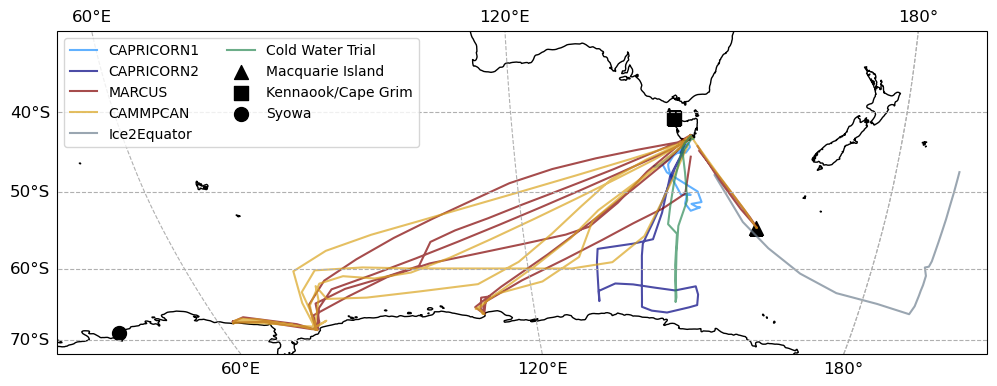

In [20]:
ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=140, globe=None))#PlateCarree(120))
ax.figure.set_size_inches(12,10)
ax.coastlines();
ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linestyle='--');
ax.set_extent((55,190,-50,-30))

colors = ['dodgerblue','navy','maroon','goldenrod',
          'slategrey','seagreen','lightsteelblue']

for i,v in enumerate(obs_names[:-4]):
    data = read_obs(v)
    data['lon'] = data.lon % 360
    plt.plot(data['lon'], 
                data['lat'],
                transform=ccrs.PlateCarree(),
                color=colors[i],alpha=0.7,
                label=v)
    

plt.scatter(x=158.861, y=-54.6199, s=100, c='black', marker='^', 
            transform=ccrs.PlateCarree(), label='Macquarie Island')

plt.scatter(x=144.6833, y=-40.68333, s=100, c='black', marker='s', 
            transform=ccrs.PlateCarree(), label='Kennaook/Cape Grim')

plt.scatter(x=39.59, y=-69.0, s=100, c='black', marker='o', 
            transform=ccrs.PlateCarree(), label='Syowa')
    
plt.legend(ncol=2,loc='upper left')


plt.rcParams.update({'font.size': 12})
plt.savefig(fig_dir+'/figures/field_observations.pdf',bbox_inches='tight')

# Figure 3 CN seasonal cycle

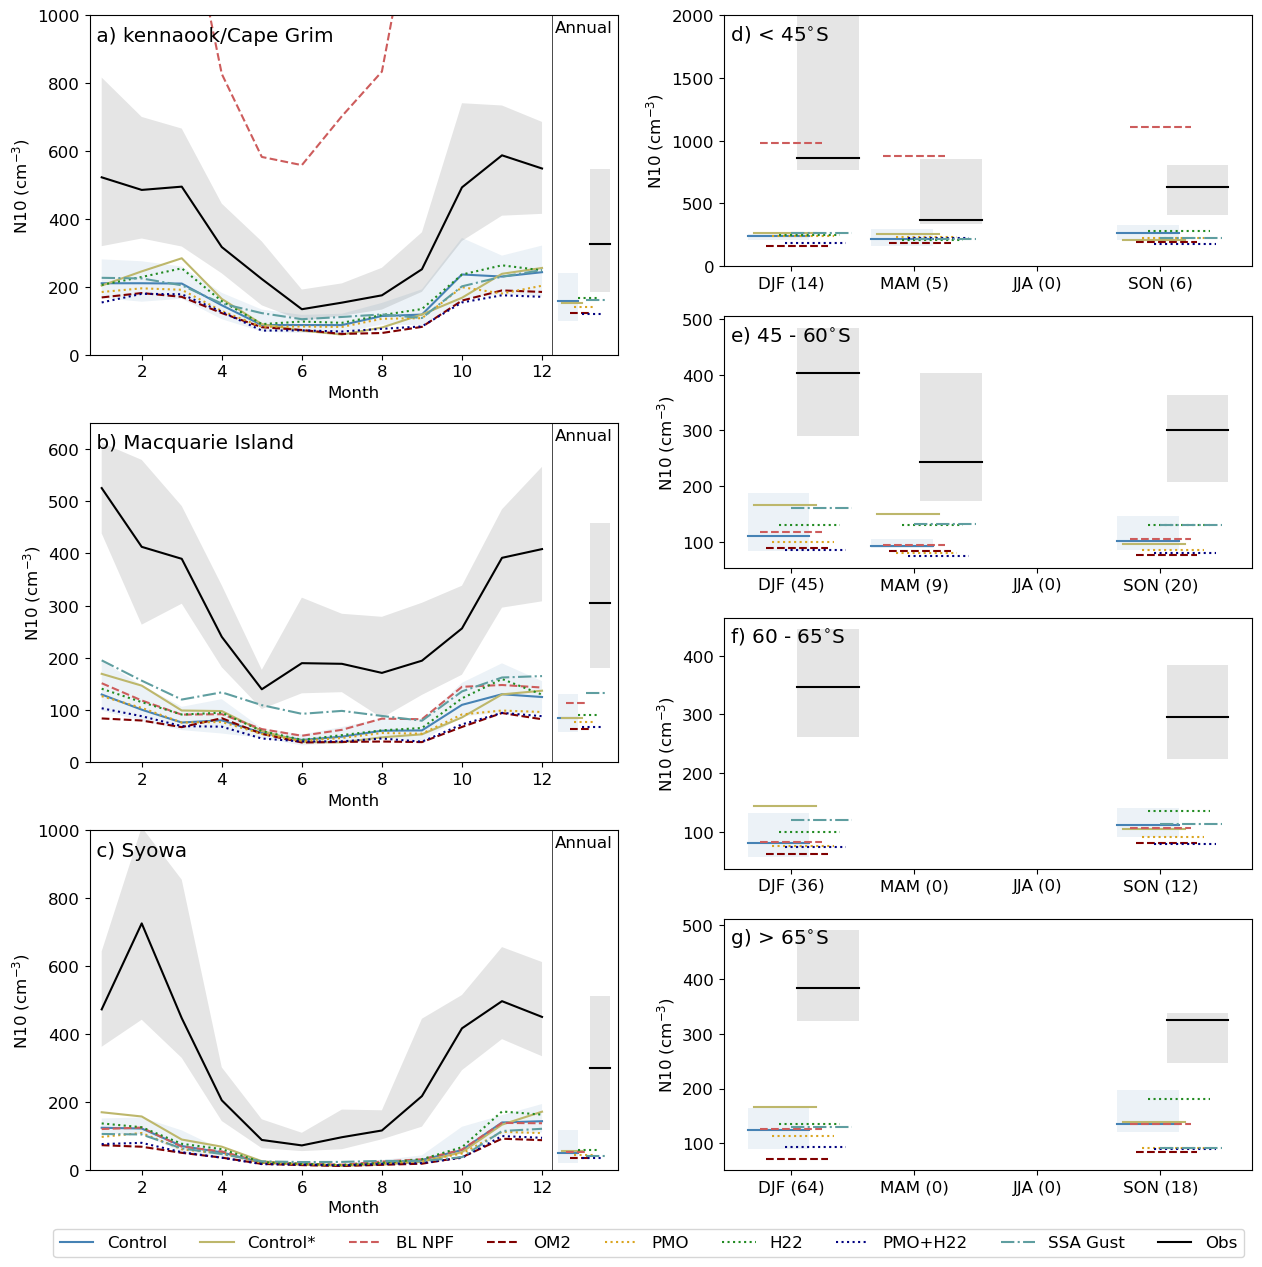

In [21]:
ax = plt.subplot(321,)
ax.figure.set_size_inches(15, 15)
data = combine_model_obs('Kennaook-Cape Grim','N10',sim='all')
plot_station_monthly(data,'N10')
plt.title(' a) kennaook/Cape Grim',y=0.9,loc='left');
plt.ylim(0,1000)

#*********************************************************************************************************************

ax = plt.subplot(323,)
data = combine_model_obs('Macquarie Island','N10',sim='all')
plot_station_monthly(data,'N10')
plt.title(' b) Macquarie Island',y=0.9,loc='left');
#plt.legend(ncols=3,loc='upper left')
plt.ylim(0,650)

#*********************************************************************************************************************
# Swoya 
ax = plt.subplot(325,)
data = combine_model_obs('Syowa','N10',sim='all')
plot_station_monthly(data,'N10')

plt.title(' c) Syowa',y=0.9,loc='left');
plt.ylim(0,1000)

#*********************************************************************************************************************
data = combine_voyage_data(obs_names[:-3],'N10')

ax = plt.subplot(422,)
lat_data = data.where((data.lat>-45))
plot_by_sea_lat(lat_data,'cn10_avg',)
plt.ylim(0,2000)
plt.title(' d) < 45$^{\circ}$S  ',y=0.87,loc='left');
plt.ylabel('N10 (cm$^{-3}$)')

ax = plt.subplot(424,)
lat_data = data.where((data.lat<-45) & (data.lat>-60))
plot_by_sea_lat(lat_data,'cn10_avg')
plt.title(' e) 45 - 60$^{\circ}$S  ',y=0.87,loc='left');
plt.ylabel('N10 (cm$^{-3}$)')

ax = plt.subplot(426,)
lat_data = data.where((data.lat<-60) & (data.lat>-65))
plot_by_sea_lat(lat_data,'cn10_avg',legend='no')
plt.title(' f) 60 - 65$^{\circ}$S  ',y=0.87,loc='left');
plt.ylabel('N10 (cm$^{-3}$)')

ax = plt.subplot(428,)
lat_data = data.where(data.lat<-65)
plot_by_sea_lat(lat_data,'cn10_avg',legend='yes')
plt.title(' g) > 65$^{\circ}$S  ',y=0.87,loc='left');
plt.ylabel('N10 (cm$^{-3}$)')

plt.savefig(fig_dir+'/figures/seasonal_CN10.pdf',bbox_inches='tight')

# Figure 4 CCN seasonal cycle

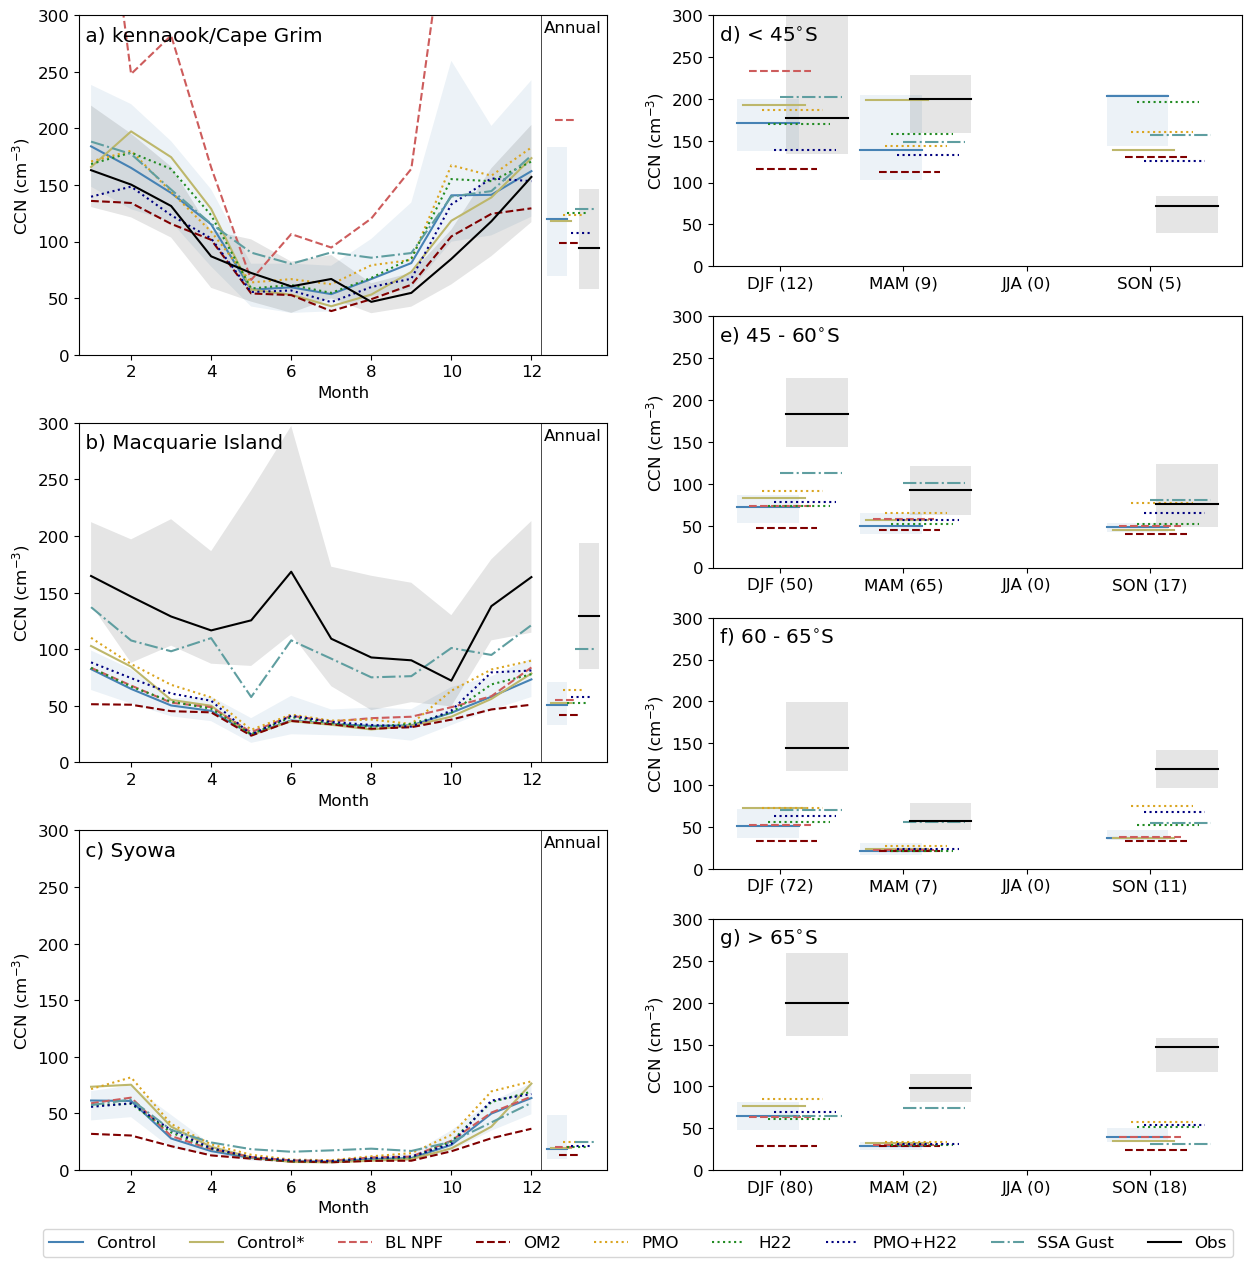

In [22]:
ax = plt.subplot(321,)
ax.figure.set_size_inches(15, 15)
data = combine_model_obs('Kennaook-Cape Grim','CCN40',sim='all')
plot_station_monthly(data,'CCN40')
plt.title(' a) kennaook/Cape Grim',y=0.9,loc='left');
plt.ylim(0,300)

#*********************************************************************************************************************

ax = plt.subplot(323,)
data = combine_model_obs('Macquarie Island','CCN40',sim='all')
plot_station_monthly(data,'CCN40')
plt.title(' b) Macquarie Island',y=0.9,loc='left');
#plt.legend(ncols=3,loc='upper left')
plt.ylim(0,300)

#*********************************************************************************************************************
# Swoya 
ax = plt.subplot(325,)
data = combine_model_obs('Syowa','CCN40',sim='all',removenans='no')
plot_station_monthly(data,'CCN40')
plt.title(' c) Syowa',y=0.9,loc='left');
plt.ylim(0,300)

#********************************************************************************************************************* 
data = combine_voyage_data(obs_names[:-3],'CCN40')

ax = plt.subplot(422,)
lat_data = data.where((data.lat>-45))
plot_by_sea_lat(lat_data,'ccn_avg',)
plt.title(' d) < 45$^{\circ}$S  ',y=0.87,loc='left');
plt.ylabel('CCN (cm$^{-3}$)')
plt.ylim(0,300)

ax = plt.subplot(424,)
lat_data = data.where((data.lat<-45) & (data.lat>-60))
plot_by_sea_lat(lat_data,'ccn_avg')
plt.title(' e) 45 - 60$^{\circ}$S  ',y=0.87,loc='left');
plt.ylabel('CCN (cm$^{-3}$)')
plt.ylim(0,300)

ax = plt.subplot(426,)
lat_data = data.where((data.lat<-60) & (data.lat>-65))
plot_by_sea_lat(lat_data,'ccn_avg',legend='no')
plt.title(' f) 60 - 65$^{\circ}$S  ',y=0.87,loc='left');
plt.ylabel('CCN (cm$^{-3}$)')
plt.ylim(0,300)

ax = plt.subplot(428,)
lat_data = data.where(data.lat<-65)
plot_by_sea_lat(lat_data,'ccn_avg',legend='yes')
plt.title(' g) > 65$^{\circ}$S  ',y=0.87,loc='left');
plt.ylabel('CCN (cm$^{-3}$)')
plt.ylim(0,300)

plt.savefig(fig_dir+'/figures/seasonal_CCN40.pdf',bbox_inches='tight')

# Figure 5 activation ratios

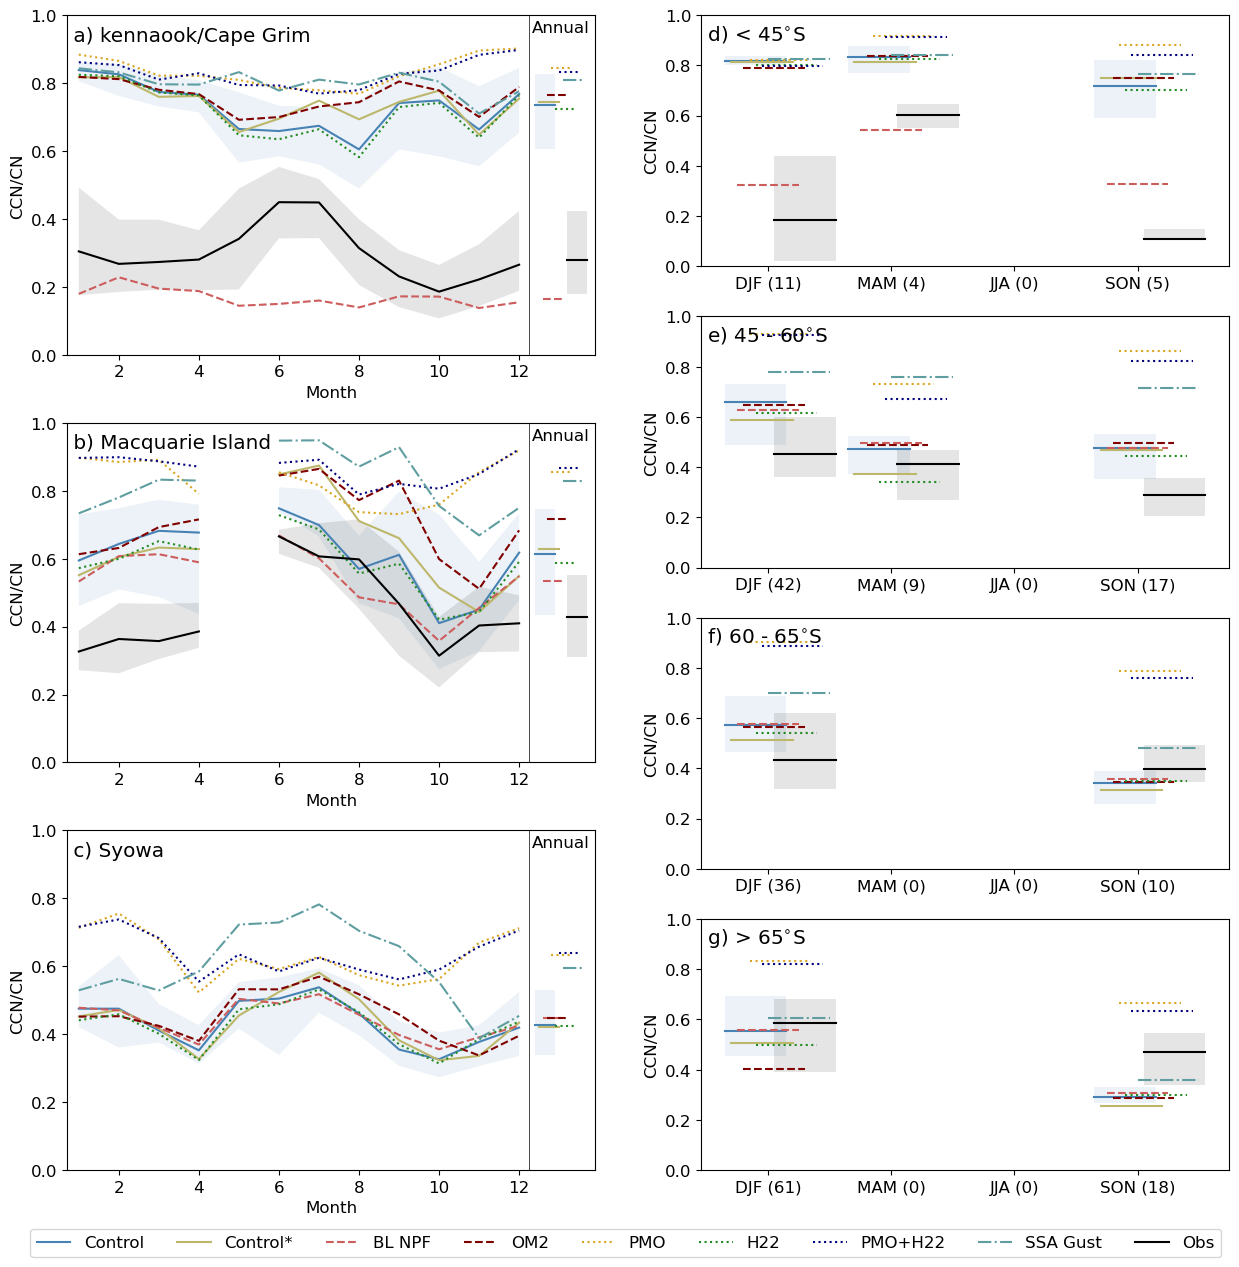

In [23]:
ax = plt.subplot(321,)
ax.figure.set_size_inches(15, 15)
dataN10 = combine_model_obs('Kennaook-Cape Grim','N10',sim='all')
dataCCN = combine_model_obs('Kennaook-Cape Grim','CCN40',sim='all')
data = dataCCN/dataN10
plot_station_monthly(data,'CCN/CN10')
plt.ylabel('CCN/CN')
plt.title(' a) kennaook/Cape Grim',y=0.9,loc='left');
plt.ylim(0,1)

#*********************************************************************************************************************

ax = plt.subplot(323,)
dataN10 = combine_model_obs('Macquarie Island','N10',sim='all')
dataCCN = combine_model_obs('Macquarie Island','CCN40',sim='all')
data = dataCCN/dataN10
plot_station_monthly(data,'CCN/CN10')
plt.ylabel('CCN/CN')
plt.title(' b) Macquarie Island',y=0.9,loc='left');
#plt.legend(ncols=3,loc='upper left')
plt.ylim(0,1)

#*********************************************************************************************************************
# Swoya 
ax = plt.subplot(325,)
dataN10 = combine_model_obs('Syowa','N10',sim='all',removenans='no')
dataCCN = combine_model_obs('Syowa','CCN40',sim='all',removenans='no')
data = dataCCN/dataN10
plot_station_monthly(data,'CCN/CN10')
plt.ylabel('CCN/CN')
plt.title(' c) Syowa',y=0.9,loc='left');
plt.ylim(0,1)

#*********************************************************************************************************************
dataCCN = combine_voyage_data(obs_names[:-3],'CCN40')
dataN10 = combine_voyage_data(obs_names[:-3],'N10')

data= dataCCN/dataN10[run]
data['lat'] = dataN10['lat']
data['lon'] = dataN10['lon']

ax = plt.subplot(422,)
lat_data = data.where((data.lat>-45))
plot_by_sea_lat(lat_data,'ccn_avg',)
plt.title(' d) < 45$^{\circ}$S  ',y=0.87,loc='left');
plt.ylabel('CCN/CN')
plt.ylim(0,1)

ax = plt.subplot(424,)
lat_data = data.where((data.lat<-45) & (data.lat>-60))
plot_by_sea_lat(lat_data,'ccn_avg')
plt.title(' e) 45 - 60$^{\circ}$S  ',y=0.87,loc='left');
plt.ylabel('CCN/CN')
plt.ylim(0,1)

ax = plt.subplot(426,)
lat_data = data.where((data.lat<-60) & (data.lat>-65))
plot_by_sea_lat(lat_data,'ccn_avg',legend='no')
plt.title(' f) 60 - 65$^{\circ}$S  ',y=0.87,loc='left');
plt.ylabel('CCN/CN')
plt.ylim(0,1)

ax = plt.subplot(428,)
lat_data = data.where(data.lat<-65)
plot_by_sea_lat(lat_data,'ccn_avg',legend='yes')
plt.title(' g) > 65$^{\circ}$S  ',y=0.87,loc='left');
plt.ylabel('CCN/CN')
plt.ylim(0,1)

plt.savefig(fig_dir+'/figures/seasonal_ratio.pdf',bbox_inches='tight')

# Station stats

## N10

In [24]:
index = pd.MultiIndex.from_product([['Kennaook-Cape Grim','Macquarie Island','Syowa'],run[:],
                                    ['Median','StdDev','MAE','\%','R$^2$']], 
                                    names=['Station','Simulation','Statistics'])
dfCN = pd.DataFrame(index=index,columns = ['DJF','MAM','JJA','SON','Ann']) 

dfCN = generate_station_tables('Kennaook-Cape Grim','N10',dfCN)
dfCN = generate_station_tables('Macquarie Island','N10',dfCN)
dfCN = generate_station_tables('Syowa','N10',dfCN)

dfCN[dfCN==0] = np.nan
dfCN[dfCN==1] = np.nan
dfCN = dfCN.dropna().astype(float).round(2)

In [25]:
dfCN.loc['Kennaook-Cape Grim']#.loc[['Obs','Control','PMO+H22']]

DJF      MAM      JJA      SON      Ann
Simulation Statistics                                             
Control    Median       217.79    98.51   142.01   198.01   158.71
           StdDev       117.69    61.90    89.67   144.98   123.37
           MAE         -294.07   -66.32  -182.31  -202.01  -149.51
           \%           -58.38   -41.57   -59.35   -56.87   -53.19
           R$^2$          0.16     0.31     0.20     0.31     0.42
Control*   Median       228.63    71.15   164.52   184.92   152.59
           StdDev       172.34    49.81   114.78   133.14   142.60
           MAE         -264.46   -89.36  -157.87  -223.08  -154.91
           \%           -54.57   -55.45   -52.06   -59.68   -55.81
           R$^2$          0.21     0.43     0.13     0.27     0.43
BL NPF     Median      1956.38   739.72   826.90  1927.60  1330.84
           StdDev      2001.23  1266.82  1408.15  2190.71  1909.63
           MAE         1316.94   599.84   445.55  1395.21   890.96
           \%           266.90   396.13   171.88   317.68   290.43
           R$^2$         -0.04     0.19    -0.06     0.22     0.26
OM2        Median       179.87    66.19   120.64   148.47   123.25
           StdDev        97.80    46.25    77.21   117.11   101.41
           MAE         -334.81   -90.15  -196.74  -269.29  -176.63
           \%           -66.42   -56.04   -66.19   -65.47   -64.20
           R$^2$         -0.00     0.22     0.10     0.37     0.41
PMO        Median       192.32    93.39   126.26   161.70   139.72
           StdDev       107.03    55.86    77.80   118.95   104.61
           MAE         -327.67   -71.78  -191.19  -247.51  -169.45
           \%           -63.56   -44.10   -63.48   -63.67   -58.62
           R$^2$          0.13     0.31     0.20     0.30     0.40
H22        Median       219.11   102.91   152.21   218.65   166.19
           StdDev       141.01    61.10   109.45   147.69   133.87
           MAE         -274.29   -62.00  -157.39  -192.97  -137.05
           \%           -56.22   -39.17   -54.00   -52.24   -49.67
           R$^2$          0.19     0.38     0.19     0.31     0.43
PMO+H22    Median       171.50    73.10   113.70   139.91   121.32
           StdDev        96.58    47.82    74.38   107.58    95.82
           MAE         -347.93   -86.11  -213.25  -266.40  -178.97
           \%           -67.78   -52.49   -66.96   -69.48   -64.52
           R$^2$          0.09     0.30     0.16     0.34     0.42
SSA Gust   Median       234.18   112.51   150.07   184.87   162.42
           StdDev       101.69    47.68    66.96   117.14   102.57
           MAE         -280.90   -51.10  -162.16  -238.47  -145.97
           \%           -55.35   -32.82   -53.31   -58.76   -49.37
           R$^2$          0.16     0.38     0.29     0.34     0.45
Obs        Median       529.65   158.18   309.24   435.96   325.63
           StdDev       320.17    93.60   210.40   430.80   342.61

In [26]:
#dfCN.loc['Kennaook-Cape Grim'].to_latex(float_format="%.2f")

In [27]:
dfCN.loc['Macquarie Island']

DJF     MAM     JJA     SON     Ann
Simulation Statistics                                        
Control    Median      117.03   53.94   67.68   94.48   85.77
           StdDev       74.82   25.54   47.71   67.13   67.72
           MAE        -317.54 -129.18 -163.68 -171.80 -195.27
           \%          -71.26  -69.05  -68.61  -63.80  -68.67
           R$^2$         0.27    0.38    0.33    0.38    0.46
Control*   Median      151.37   41.27   77.89   78.12   85.21
           StdDev      133.42   21.07   63.80   69.13  105.21
           MAE        -278.76 -138.11 -143.43 -188.48 -186.36
           \%          -64.00  -76.29  -61.51  -68.39  -67.11
           R$^2$         0.28    0.38    0.38    0.42    0.50
BL NPF     Median      141.31   68.06   79.82  130.43  114.67
           StdDev       82.61   71.08   64.16   85.58   83.55
           MAE        -289.34  -99.34 -154.00 -139.04 -171.24
           \%          -66.91  -58.76  -62.98  -55.75  -61.38
           R$^2$         0.17    0.34    0.28    0.23    0.34
OM2        Median       82.90   39.31   62.11   62.47   64.56
           StdDev       38.39   19.03   36.34   38.37   39.01
           MAE        -360.05 -139.12 -164.68 -206.61 -229.76
           \%          -80.39  -78.02  -72.58  -76.44  -77.68
           R$^2$         0.21    0.39    0.38    0.48    0.48
PMO        Median      106.14   49.83   64.08   80.84   78.00
           StdDev       65.53   23.98   45.57   47.37   56.47
           MAE        -323.47 -131.61 -162.47 -189.15 -208.25
           \%          -74.75  -71.97  -69.47  -71.39  -72.61
           R$^2$         0.30    0.38    0.36    0.39    0.49
H22        Median      126.85   55.86   73.23  100.59   91.27
           StdDev       90.50   26.29   65.93   87.64   84.10
           MAE        -303.01 -126.63 -138.37 -170.05 -185.87
           \%          -69.96  -66.98  -62.35  -61.93  -65.90
           R$^2$         0.25    0.35    0.34    0.40    0.45
PMO+H22    Median       89.87   41.44   60.27   65.89   67.93
           StdDev       51.18   21.09   41.33   50.01   49.01
           MAE        -346.10 -136.41 -173.54 -197.77 -219.71
           \%          -78.72  -76.12  -73.05  -75.39  -76.09
           R$^2$         0.27    0.41    0.37    0.44    0.49
SSA Gust   Median      169.73   95.05  119.09  127.86  131.99
           StdDev       70.26   42.44   51.76   67.83   68.68
           MAE        -269.24  -93.23 -121.45 -138.38 -153.50
           \%          -60.02  -46.37  -46.34  -55.90  -54.94
           R$^2$         0.39    0.50    0.46    0.51    0.57
Obs        Median      458.09  185.27  241.91  271.74  305.12
           StdDev      195.17  121.68  163.91  173.03  198.49

In [28]:
dfCN.loc['Syowa']

DJF     MAM     JJA     SON     Ann
Simulation Statistics                                        
Control    Median      128.15   16.65   42.51   65.36   51.62
           StdDev       54.31    8.52   36.99   69.18   66.06
           MAE        -384.22  -81.71 -166.97 -319.47 -205.69
           \%          -74.24  -80.84  -77.29  -80.86  -78.48
           R$^2$         0.08    0.22    0.01    0.12    0.38
Control*   Median      163.91   14.26   56.05   58.62   56.05
           StdDev      154.05    6.42   48.70   60.34  107.07
           MAE        -339.42  -83.82 -149.55 -321.10 -194.87
           \%          -69.38  -83.92  -72.84  -82.81  -77.31
           R$^2$         0.18    0.22   -0.05    0.18    0.37
BL NPF     Median      126.16   18.99   46.60   63.97   52.23
           StdDev       52.34    9.02   36.29   64.91   63.22
           MAE        -385.44  -79.59 -164.96 -319.39 -209.18
           \%          -75.59  -79.21  -76.62  -80.64  -77.86
           R$^2$         0.07    0.23    0.01    0.13    0.38
OM2        Median       78.01   14.18   31.78   38.63   34.35
           StdDev       26.90    5.68   25.02   46.64   38.61
           MAE        -432.12  -84.81 -175.83 -351.48 -236.81
           \%          -85.16  -84.69  -82.34  -88.80  -85.28
           R$^2$        -0.12    0.19   -0.02    0.12    0.33
PMO        Median      105.09   16.78   39.67   52.19   44.60
           StdDev       41.33    7.70   31.31   45.60   48.90
           MAE        -406.45  -81.01 -168.32 -336.65 -222.51
           \%          -80.00  -80.62  -79.05  -84.49  -80.73
           R$^2$         0.05    0.22   -0.01    0.11    0.38
H22        Median      137.79   17.26   51.33   69.33   58.83
           StdDev       85.95    8.86   41.55   85.19   81.69
           MAE        -357.10  -81.40 -157.95 -298.32 -194.78
           \%          -73.61  -80.17  -74.65  -79.69  -77.17
           R$^2$         0.07    0.23    0.01    0.23    0.37
PMO+H22    Median       84.20   15.49   32.40   39.74   35.49
           StdDev       36.42    6.05   25.17   42.72   41.00
           MAE        -419.51  -83.31 -178.75 -351.71 -236.23
           \%          -84.28  -82.76  -82.82  -87.43  -83.92
           R$^2$         0.07    0.24   -0.04    0.15    0.38
SSA Gust   Median      110.41   24.58   41.44   41.57   42.11
           StdDev       45.93    7.84   28.44   53.72   52.39
           MAE        -395.55  -71.54 -167.64 -333.94 -220.86
           \%          -77.83  -73.41  -78.03  -84.43  -78.56
           R$^2$        -0.00    0.23    0.13    0.13    0.36
Obs        Median      506.88   99.83  205.71  407.78  300.41
           StdDev      421.89  119.40  526.52  344.83  427.03
           R$^2$         1.00    1.00    1.00    1.00    1.00

## CCN

In [29]:
index = pd.MultiIndex.from_product([['Kennaook-Cape Grim','Macquarie Island','Syowa'],run[:],
                                    ['Median','StdDev','MAE','\%','R$^2$']], 
                                    names=['Station','Simulation','Statistics'])
dfCCN = pd.DataFrame(index=index,columns = ['DJF','MAM','JJA','SON','Ann']) 

dfCCN = generate_station_tables('Kennaook-Cape Grim','CCN40',dfCCN)
dfCCN = generate_station_tables('Macquarie Island','CCN40',dfCCN)
dfCCN = generate_station_tables('Syowa','CCN40',dfCCN)

dfCCN[dfCCN==0] = np.nan
dfCCN[dfCCN==1] = np.nan
dfCCN = dfCCN.dropna().astype(float).round(2)

In [30]:
dfCCN.loc['Kennaook-Cape Grim']

DJF     MAM     JJA      SON     Ann
Simulation Statistics                                         
Control    Median      168.42   61.66  111.21   126.94  119.69
           StdDev       91.31   54.19   76.60   113.45   99.03
           MAE          15.73    4.17   11.33    44.15   18.28
           \%            8.96    6.32   11.38    61.18   19.73
           R$^2$         0.18    0.25    0.11     0.16    0.34
Control*   Median      174.64   49.50  128.78   116.10  118.40
           StdDev      105.81   45.05   90.73   106.69  104.82
           MAE          17.26   -5.58   27.48    32.00   16.44
           \%           11.40   -9.81   27.20    50.52   17.51
           R$^2$         0.12    0.30    0.12     0.19    0.37
BL NPF     Median      369.62  106.03  149.89   288.44  207.00
           StdDev      559.52  258.59  327.22  1226.08  769.30
           MAE         225.14   47.23   54.73   215.11  104.70
           \%          143.02  104.99   81.21   234.52  134.28
           R$^2$         0.15    0.16    0.04    -0.04    0.11
OM2        Median      132.64   49.19   96.42    99.58   98.43
           StdDev       86.97   42.91   64.72    93.78   84.75
           MAE         -15.54   -9.73   -3.62    18.89   -3.68
           \%          -11.17  -14.57   -3.92    28.71   -4.39
           R$^2$         0.16    0.21    0.16     0.25    0.34
PMO        Median      175.97   69.33  107.18   143.43  123.06
           StdDev       85.36   51.22   69.25   105.97   92.74
           MAE          11.55   12.20   11.28    53.37   21.91
           \%            7.87   21.69   12.66    73.01   22.68
           R$^2$         0.16    0.25    0.07     0.18    0.33
H22        Median      170.78   62.38  119.38   134.97  125.58
           StdDev       94.00   52.96   86.09   113.21  101.12
           MAE          13.94    4.57   19.14    52.69   20.88
           \%            8.23    8.03   21.82    74.98   23.36
           R$^2$         0.14    0.28    0.10     0.19    0.33
PMO+H22    Median      147.95   55.34   97.15   119.40  107.49
           StdDev       77.82   45.39   66.80    94.09   83.74
           MAE          -9.74   -0.79   -3.81    31.89    4.69
           \%           -5.98   -1.88   -3.48    40.34    5.66
           R$^2$         0.13    0.27    0.12     0.23    0.33
SSA Gust   Median      182.58   84.37  119.41   129.76  129.07
           StdDev       78.95   44.00   59.01    94.25   83.30
           MAE          22.18   21.57   18.21    42.10   26.83
           \%           14.60   46.96   20.40    53.59   29.94
           R$^2$         0.22    0.35    0.32     0.23    0.42
Obs        Median      156.64   57.12   98.46    82.23   94.36
           StdDev       80.90   31.02   49.48    49.25   69.23
           R$^2$         1.00    1.00    1.00     1.00    1.00

In [31]:
dfCCN.loc['Macquarie Island']

DJF     MAM     JJA     SON     Ann
Simulation Statistics                                        
Control    Median       73.79   34.02   42.34   45.86   50.37
           StdDev       26.95   21.96   21.95   27.23   29.00
           MAE         -79.56  -77.54  -77.59  -60.50  -72.51
           \%          -52.90  -66.96  -66.08  -55.77  -58.73
           R$^2$         0.33    0.26    0.30    0.47    0.33
Control*   Median       86.17   32.84   48.04   42.97   52.18
           StdDev       42.66   20.56   23.26   26.47   38.82
           MAE         -61.44  -80.10  -71.03  -62.92  -68.79
           \%          -41.26  -70.33  -62.56  -58.44  -56.39
           R$^2$         0.27    0.22    0.33    0.50    0.30
BL NPF     Median       79.41   38.51   45.40   50.62   55.45
           StdDev       34.31   38.76   37.51   43.08   41.05
           MAE         -69.86  -71.82  -72.22  -49.73  -65.82
           \%          -49.13  -61.88  -61.68  -50.36  -54.40
           R$^2$         0.36    0.29    0.25    0.40    0.32
OM2        Median       51.00   32.23   41.18   38.01   41.86
           StdDev       19.00   19.91   20.31   24.11   22.16
           MAE        -106.81  -80.38  -78.06  -69.33  -83.99
           \%          -65.76  -70.80  -68.19  -64.79  -66.19
           R$^2$         0.32    0.27    0.34    0.45    0.35
PMO        Median       95.51   37.66   51.98   60.93   64.21
           StdDev       36.82   22.47   24.21   34.36   38.24
           MAE         -53.62  -72.53  -69.44  -41.38  -58.92
           \%          -38.27  -62.44  -58.36  -41.77  -48.26
           R$^2$         0.24    0.15    0.25    0.39    0.25
H22        Median       77.44   34.30   44.26   49.11   52.58
           StdDev       27.80   21.95   22.85   32.52   31.30
           MAE         -76.95  -77.76  -72.52  -50.13  -69.02
           \%          -50.54  -67.53  -64.19  -51.49  -55.92
           R$^2$         0.34    0.24    0.30    0.46    0.33
PMO+H22    Median       81.75   35.55   47.90   51.61   57.54
           StdDev       29.29   21.67   23.19   36.82   33.91
           MAE         -72.20  -77.43  -71.05  -46.94  -65.64
           \%          -45.50  -67.15  -61.00  -48.00  -54.94
           R$^2$         0.28    0.16    0.29    0.44    0.29
SSA Gust   Median      118.90   89.89   95.23   90.40  100.59
           StdDev       43.29   45.12   47.98   48.22   47.90
           MAE         -28.46  -23.61  -32.81  -20.92  -24.74
           \%          -19.10  -22.52  -28.73  -18.91  -20.43
           R$^2$         0.31    0.31    0.41    0.47    0.39
Obs        Median      158.51  116.01  118.86  105.96  129.01
           StdDev       73.53  105.81  133.77   88.25  100.03
           R$^2$         1.00    1.00    1.00    1.00    1.00

In [32]:
dfCCN.loc['Syowa']

DJF    MAM    JJA    SON    Ann
Simulation Statistics                                   
Control    Median      61.81   8.00  16.05  23.31  18.46
           StdDev      21.41   3.10  15.90  19.94  26.01
           R$^2$         NaN    NaN    NaN    NaN    NaN
Control*   Median      74.45   7.35  18.96  19.35  19.12
           StdDev      31.59   2.57  22.28  16.85  34.49
           R$^2$         NaN    NaN    NaN    NaN    NaN
BL NPF     Median      62.29   8.99  16.86  25.92  20.16
           StdDev      21.78   3.58  16.14  19.88  25.97
           R$^2$         NaN    NaN    NaN    NaN    NaN
OM2        Median      32.98   7.51  12.74  15.69  13.71
           StdDev      11.68   2.41  10.20  12.29  14.03
           R$^2$         NaN    NaN    NaN    NaN    NaN
PMO        Median      77.84   9.55  22.71  31.11  24.62
           StdDev      23.26   3.69  18.98  27.66  32.28
           R$^2$         NaN    NaN    NaN    NaN    NaN
H22        Median      61.06   8.23  17.18  25.97  20.22
           StdDev      22.66   3.20  16.96  23.99  27.86
           R$^2$         NaN    NaN    NaN    NaN    NaN
PMO+H22    Median      61.74   8.82  19.32  23.39  20.88
           StdDev      21.34   3.00  15.40  25.85  27.14
           R$^2$         NaN    NaN    NaN    NaN    NaN
SSA Gust   Median      58.95  17.63  23.73  24.14  25.18
           StdDev      19.71   6.49  13.19  14.47  21.18
           R$^2$         NaN    NaN    NaN    NaN    NaN
Obs        R$^2$         NaN    NaN    NaN    NaN    NaN

# Voyage stats

## N10

In [33]:
index = pd.MultiIndex.from_product([['<45S','45-60S','60-65S','>65S'],run[:],
                                ['Median','StdDev','MAE','\%','R$^2$']], 
                                names=['Latitude','Simulation','Statistics'])
dfCN_voyages = pd.DataFrame(index=index,columns = ['DJF','MAM','SON','Ann']) 

data = combine_voyage_data(obs_names[:-4],'N10')
dfCN_voyages = generate_voyage_tables(data,'<45S',dfCN_voyages)
dfCN_voyages = generate_voyage_tables(data,'45-60S',dfCN_voyages)
dfCN_voyages = generate_voyage_tables(data,'60-65S',dfCN_voyages)
dfCN_voyages = generate_voyage_tables(data,'>65S',dfCN_voyages)

dfCN_voyages[dfCN_voyages==0] = np.nan
dfCN_voyages[dfCN_voyages==1] = np.nan
dfCN_voyages = dfCN_voyages.astype(float).round(2)

In [34]:
dfCN_voyages.loc['<45S']

DJF     MAM      SON      Ann
Simulation Statistics                                   
Control    Median       243.40  215.30   260.92   241.20
           StdDev        74.12  171.53    90.03   105.75
           MAE         -628.79 -237.50  -329.99  -567.01
           \%           -73.68  -63.27   -61.45   -70.57
           R$^2$         -0.34    0.85     0.18    -0.16
Control*   Median       262.74  254.10   207.97   254.10
           StdDev       114.37  175.73   116.20   131.12
           MAE         -595.76 -188.40  -326.43  -538.14
           \%           -71.85  -55.98   -68.66   -70.11
           R$^2$         -0.32    0.88     0.54    -0.15
BL NPF     Median       981.33  876.07  1109.71   944.99
           StdDev      2457.18  312.53   568.67  1938.87
           MAE          188.51  -19.78   419.14   179.93
           \%            24.00   -2.33    51.20    23.97
           R$^2$         -0.32    0.36    -0.27    -0.18
OM2        Median       159.86  182.62   192.24   161.67
           StdDev        55.62   60.06   107.81    78.60
           MAE         -650.11 -233.76  -360.90  -590.77
           \%           -78.70  -66.59   -74.03   -74.90
           R$^2$         -0.34    0.25     0.56    -0.21
PMO        Median       241.53  231.89   225.47   238.49
           StdDev        74.44  164.90   110.02   107.92
           MAE         -624.55 -224.17  -349.97  -582.09
           \%           -72.78  -63.68   -70.36   -70.94
           R$^2$         -0.34    0.88     0.50    -0.13
H22        Median       247.99  211.07   282.50   246.63
           StdDev       100.32  177.30    86.20   118.01
           MAE         -616.79 -214.06  -302.98  -541.98
           \%           -71.85  -61.18   -54.20   -66.05
           R$^2$         -0.34    0.84     0.36    -0.19
PMO+H22    Median       188.17  223.91   175.29   197.18
           StdDev        70.80  168.38    96.54   106.85
           MAE         -641.52 -234.96  -377.64  -601.89
           \%           -76.88  -63.76   -74.07   -73.66
           R$^2$         -0.36    0.89     0.48    -0.16
SSA Gust   Median       266.28  214.55   223.96   237.58
           StdDev        71.02  178.35    93.66   106.54
           MAE         -595.57 -214.89  -326.47  -580.39
           \%           -70.27  -61.09   -60.73   -66.40
           R$^2$         -0.36    0.90     0.57    -0.10
Obs        Median       858.50  369.34   633.76   820.58
           StdDev      3482.37  507.74   444.60  2807.23
           MAE             NaN     NaN      NaN      NaN
           \%              NaN     NaN      NaN      NaN
           R$^2$          1.00    1.00     1.00     1.00

In [35]:
dfCN_voyages.loc['45-60S']

DJF     MAM     SON     Ann
Simulation Statistics                                
Control    Median      111.03   93.69  102.23  104.79
           StdDev       76.57   36.94   48.05   67.17
           MAE        -267.09 -153.49 -143.78 -237.78
           \%          -71.74  -63.01  -64.31  -68.61
           R$^2$         0.12   -0.48   -0.27    0.10
Control*   Median      167.15  150.68   96.93  147.20
           StdDev      105.58   52.84   46.81   94.73
           MAE        -231.41 -143.91 -157.49 -197.50
           \%          -59.06  -56.40  -69.51  -59.07
           R$^2$         0.05   -0.17   -0.20    0.14
BL NPF     Median      117.96   95.35  105.02  109.52
           StdDev      509.47   41.23   66.62  406.00
           MAE        -230.93 -137.91 -146.16 -219.83
           \%          -65.63  -57.41  -64.71  -64.04
           R$^2$         0.14   -0.57   -0.17    0.17
OM2        Median       89.79   84.45   77.48   84.60
           StdDev       43.34   27.06   32.97   38.97
           MAE        -325.87 -159.34 -194.44 -274.48
           \%          -78.49  -65.41  -74.28  -75.00
           R$^2$         0.16   -0.54   -0.25    0.09
PMO        Median      100.87   79.62   86.13   91.88
           StdDev       66.15   40.36   33.58   58.64
           MAE        -275.70 -137.43 -188.65 -256.95
           \%          -74.87  -62.46  -72.07  -73.25
           R$^2$         0.22   -0.58   -0.22    0.21
H22        Median      131.22  130.58  130.94  130.90
           StdDev       86.81   55.03   67.62   79.06
           MAE        -244.63 -152.08 -125.47 -209.17
           \%          -65.02  -61.64  -51.19  -62.31
           R$^2$         0.10   -0.21   -0.25    0.06
PMO+H22    Median       86.09   74.91   81.09   84.34
           StdDev       55.73   33.63   33.03   49.40
           MAE        -287.97 -143.01 -181.67 -264.58
           \%          -73.29  -63.89  -73.97  -73.40
           R$^2$         0.28   -0.57   -0.08    0.24
SSA Gust   Median      161.56  132.20  130.38  144.07
           StdDev       63.43   24.17   45.40   57.99
           MAE        -228.55 -111.41 -159.32 -193.50
           \%          -62.74  -45.73  -59.35  -61.72
           R$^2$         0.34   -0.56   -0.14    0.32
Obs        Median      403.21  243.60  301.27  359.56
           StdDev      191.20  128.58  104.01  177.73
           MAE            NaN     NaN     NaN     NaN
           \%             NaN     NaN     NaN     NaN
           R$^2$          NaN    1.00    1.00    1.00

In [36]:
dfCN_voyages.loc['60-65S']

DJF  MAM     SON     Ann
Simulation Statistics                             
Control    Median       80.62  NaN  110.96   90.58
           StdDev       53.50  NaN   50.06   53.72
           MAE        -241.02  NaN -191.91 -215.91
           \%          -73.55  NaN  -57.09  -68.87
           R$^2$         0.47  NaN   -0.07    0.33
Control*   Median      143.58  NaN  105.38  120.19
           StdDev       77.95  NaN   49.16   73.29
           MAE        -196.86  NaN -202.52 -199.51
           \%          -56.47  NaN  -62.33  -57.83
           R$^2$         0.53  NaN   -0.13    0.48
BL NPF     Median       83.17  NaN  106.79   87.96
           StdDev       50.16  NaN   47.35   50.24
           MAE        -239.79  NaN -202.34 -221.34
           \%          -72.16  NaN  -57.95  -70.41
           R$^2$         0.49  NaN   -0.09    0.35
OM2        Median       62.93  NaN   80.29   67.63
           StdDev       65.48  NaN   25.01   56.48
           MAE        -243.98  NaN -231.99 -237.53
           \%          -74.29  NaN  -71.56  -74.29
           R$^2$         0.62  NaN   -0.16    0.54
PMO        Median       76.48  NaN   90.69   80.42
           StdDev       45.63  NaN   24.51   41.37
           MAE        -251.57  NaN -234.58 -251.57
           \%          -76.80  NaN  -71.83  -74.87
           R$^2$         0.40  NaN   -0.17    0.34
H22        Median      100.13  NaN  135.43  109.11
           StdDev       53.48  NaN   70.77   61.34
           MAE        -219.13  NaN -124.18 -203.33
           \%          -68.37  NaN  -42.68  -64.69
           R$^2$         0.52  NaN    0.01    0.30
PMO+H22    Median       74.83  NaN   79.48   74.97
           StdDev       38.95  NaN   21.59   35.46
           MAE        -262.06  NaN -234.97 -256.41
           \%          -75.71  NaN  -74.14  -75.36
           R$^2$         0.49  NaN   -0.26    0.40
SSA Gust   Median      120.60  NaN  113.83  119.57
           StdDev       42.69  NaN   26.10   39.27
           MAE        -224.58  NaN -207.16 -219.38
           \%          -66.14  NaN  -64.59  -65.86
           R$^2$         0.41  NaN    0.07    0.38
Obs        Median      346.65  NaN  295.44  341.38
           StdDev      186.75  NaN  108.50  173.86
           MAE            NaN  NaN     NaN     NaN
           \%             NaN  NaN     NaN     NaN
           R$^2$         1.00  NaN    1.00     NaN

In [37]:
dfCN_voyages.loc['>65S']

DJF  MAM     SON     Ann
Simulation Statistics                             
Control    Median      123.93  NaN  135.80  128.37
           StdDev       66.44  NaN   51.78   63.98
           MAE        -258.77  NaN -162.92 -236.35
           \%          -71.41  NaN  -47.33  -67.13
           R$^2$         0.09  NaN   -0.12    0.04
Control*   Median      165.42  NaN  139.06  158.00
           StdDev       90.06  NaN   51.36   83.81
           MAE        -213.81  NaN -164.86 -200.65
           \%          -60.14  NaN  -46.89  -56.63
           R$^2$         0.16  NaN   -0.10    0.17
BL NPF     Median      125.87  NaN  134.81  127.92
           StdDev       60.93  NaN   50.14   59.12
           MAE        -248.48  NaN -161.26 -235.62
           \%          -71.24  NaN  -47.93  -66.00
           R$^2$         0.15  NaN   -0.03    0.09
OM2        Median       71.63  NaN   83.53   74.82
           StdDev       43.10  NaN   39.75   42.83
           MAE        -301.18  NaN -210.42 -260.34
           \%          -83.34  NaN  -63.30  -78.92
           R$^2$        -0.11  NaN    0.13   -0.11
PMO        Median      113.32  NaN   91.80  108.48
           StdDev       42.78  NaN   40.72   42.73
           MAE        -270.87  NaN -204.26 -243.57
           \%          -73.99  NaN  -61.51  -72.69
           R$^2$         0.16  NaN    0.03    0.17
H22        Median      134.82  NaN  180.92  143.20
           StdDev       75.30  NaN   54.62   74.63
           MAE        -254.50  NaN -107.42 -223.43
           \%          -68.48  NaN  -34.00  -63.87
           R$^2$         0.17  NaN   -0.16    0.06
PMO+H22    Median       93.25  NaN   89.64   90.86
           StdDev       43.94  NaN   36.80   42.48
           MAE        -284.03  NaN -212.90 -263.49
           \%          -77.46  NaN  -63.69  -75.50
           R$^2$         0.08  NaN    0.00    0.07
SSA Gust   Median      129.82  NaN   91.94  125.33
           StdDev       66.77  NaN   41.36   62.88
           MAE        -263.34  NaN -206.73 -242.48
           \%          -71.78  NaN  -64.25  -69.99
           R$^2$         0.17  NaN    0.04    0.19
Obs        Median      385.00  NaN  325.79  365.82
           StdDev      258.90  NaN  141.71  245.50
           MAE            NaN  NaN     NaN     NaN
           \%             NaN  NaN     NaN     NaN
           R$^2$          NaN  NaN    1.00     NaN

## CCN 

In [38]:
index = pd.MultiIndex.from_product([['<45S','45-60S','60-65S','>65S'],run[:],
                                ['Median','StdDev','MAE','\%','R$^2$']], 
                                names=['Latitude','Simulation','Statistics'])
dfCCN_voyages = pd.DataFrame(index=index,columns = ['DJF','MAM','SON','Ann']) 

data = combine_voyage_data(obs_names[:-4],'CCN40')
dfCCN_voyages = generate_voyage_tables(data,'<45S',dfCCN_voyages)
dfCCN_voyages = generate_voyage_tables(data,'45-60S',dfCCN_voyages)
dfCCN_voyages = generate_voyage_tables(data,'60-65S',dfCCN_voyages)
dfCCN_voyages = generate_voyage_tables(data,'>65S',dfCCN_voyages)

dfCCN_voyages[dfCCN_voyages==0] = np.nan
dfCCN_voyages[dfCCN_voyages==1] = np.nan
dfCCN_voyages = dfCCN_voyages.astype(float).round(2)

In [39]:
dfCCN_voyages.loc['<45S']

DJF     MAM     SON     Ann
Simulation Statistics                                
Control    Median      171.75  139.25  203.02  156.78
           StdDev       55.13   53.39   88.83   65.96
           MAE         -52.87  -93.03   99.27  -39.56
           \%          -20.05  -43.72   97.46  -19.41
           R$^2$         0.70    0.36    0.46    0.32
Control*   Median      205.85  184.84  139.19  169.26
           StdDev       54.82   57.30  107.72   70.49
           MAE         -44.16  -65.82   53.18  -13.01
           \%          -20.60  -26.18   73.39   -7.70
           R$^2$         0.51    0.46    0.39    0.36
BL NPF     Median      252.58  353.94  379.60  316.09
           StdDev      619.93  224.25  177.35  459.16
           MAE          86.81   48.90  273.59   90.60
           \%           16.76   26.87  258.08   85.15
           R$^2$         0.62    0.64    0.09    0.56
OM2        Median      119.13   95.85  130.89  119.13
           StdDev       57.32   53.30   98.61   69.13
           MAE        -109.52 -108.34   35.54  -70.43
           \%          -50.87  -53.06   49.05  -42.15
           R$^2$         0.45    0.51    0.38    0.24
PMO        Median      200.61  134.36  160.34  165.62
           StdDev       63.07   56.57  103.88   73.89
           MAE         -39.02  -87.99  123.34   -9.31
           \%          -27.92  -41.70  173.36   -2.67
           R$^2$         0.58    0.26    0.54    0.28
H22        Median      177.43  155.83  196.12  171.29
           StdDev       62.80   53.10   88.20   68.00
           MAE         -36.50  -82.66   92.70  -23.71
           \%          -26.11  -37.27  127.94   -9.85
           R$^2$         0.64    0.26    0.46    0.30
PMO+H22    Median      144.85  120.68  125.31  132.55
           StdDev       53.16   59.68   94.26   66.19
           MAE         -86.97  -98.94   58.41  -32.02
           \%          -39.46  -46.87  116.17  -22.46
           R$^2$         0.43    0.26    0.49    0.23
SSA Gust   Median      191.48  141.98  156.96  157.20
           StdDev       59.03   39.24   80.55   63.02
           MAE         -40.67  -77.42   69.81  -23.81
           \%          -15.42  -36.45  172.27  -10.20
           R$^2$         0.78    0.46    0.27    0.43
Obs        Median      176.61  201.93   72.46  158.19
           StdDev      175.82  154.75   28.38  167.02
           MAE            NaN     NaN     NaN     NaN
           \%             NaN     NaN     NaN     NaN
           R$^2$         1.00    1.00    1.00    1.00

In [40]:
dfCCN_voyages.loc['45-60S']

DJF    MAM    SON     Ann
Simulation Statistics                              
Control    Median       72.44  48.57  48.24   54.58
           StdDev       37.24  25.59  12.42   31.69
           MAE        -105.50 -37.70 -15.59  -52.46
           \%          -58.16 -42.34 -28.69  -46.46
           R$^2$         0.42   0.45   0.12    0.54
Control*   Median       85.83  56.46  44.94   60.85
           StdDev       39.41  28.66  11.35   36.45
           MAE         -81.76 -32.05 -26.52  -43.70
           \%          -48.22 -30.72 -37.44  -39.34
           R$^2$         0.19   0.51   0.24    0.50
BL NPF     Median       74.65  52.55  50.11   58.68
           StdDev       74.01  75.62  16.16   71.37
           MAE         -97.63 -33.36 -17.00  -45.92
           \%          -58.59 -36.27 -26.15  -41.95
           R$^2$         0.54   0.32   0.14    0.44
OM2        Median       47.96  43.71  40.38   43.71
           StdDev       25.63  25.56  12.60   24.34
           MAE        -140.94 -36.20 -34.21  -57.15
           \%          -73.44 -43.55 -46.40  -59.31
           R$^2$         0.45   0.49   0.21    0.41
PMO        Median       92.09  64.11  77.31   75.06
           StdDev       45.00  30.57  22.85   39.36
           MAE         -81.68 -28.37   5.95  -33.19
           \%          -43.00 -28.81   7.89  -30.88
           R$^2$         0.29   0.45  -0.06    0.48
H22        Median       74.62  50.84  52.57   58.90
           StdDev       35.67  27.06  12.11   31.48
           MAE         -98.60 -35.98 -13.55  -49.23
           \%          -55.20 -37.83 -23.35  -42.88
           R$^2$         0.35   0.49   0.25    0.52
PMO+H22    Median       80.04  56.31  64.66   65.08
           StdDev       36.42  29.75  21.96   33.78
           MAE         -90.85 -32.86   0.68  -42.94
           \%          -52.26 -36.88   1.71  -39.22
           R$^2$         0.22   0.41   0.14    0.42
SSA Gust   Median      115.70  99.91  81.09   99.91
           StdDev       43.78  40.29  28.93   41.57
           MAE         -71.64  14.91  10.67   -6.88
           \%          -38.49  16.78  19.34   -7.51
           R$^2$         0.38   0.42   0.23    0.43
Obs        Median      183.66  89.02  75.40  111.02
           StdDev       81.52  43.86  43.67   77.50
           MAE            NaN    NaN    NaN     NaN
           \%             NaN    NaN    NaN     NaN
           R$^2$         1.00   1.00    NaN    1.00

In [41]:
dfCCN_voyages.loc['60-65S']

DJF    MAM     SON     Ann
Simulation Statistics                               
Control    Median       51.36  20.87   36.31   41.74
           StdDev       30.53   9.41   12.49   28.35
           MAE        -104.39 -22.96  -67.67  -88.07
           \%          -64.48 -51.48  -64.44  -64.44
           R$^2$         0.60   0.45   -0.07    0.63
Control*   Median       68.54  23.71   36.65   54.67
           StdDev       36.25   9.24   12.17   35.99
           MAE         -88.60 -21.75  -73.19  -73.53
           \%          -50.43 -46.55  -70.27  -54.96
           R$^2$         0.69   0.43   -0.16    0.71
BL NPF     Median       51.90  21.97   37.56   43.82
           StdDev       30.21  10.66   13.37   28.09
           MAE        -105.27 -22.99  -67.92  -88.27
           \%          -64.54 -48.91  -65.20  -64.54
           R$^2$         0.59   0.53   -0.08    0.62
OM2        Median       36.11  21.22   32.66   32.81
           StdDev       21.68   9.55    8.32   19.08
           MAE        -112.68 -22.35  -87.53  -91.69
           \%          -73.04 -50.65  -76.46  -73.33
           R$^2$         0.61   0.34   -0.35    0.59
PMO        Median       72.76  26.73   74.92   61.75
           StdDev       39.48   9.75   17.52   37.40
           MAE         -80.65 -18.94  -44.70  -66.71
           \%          -43.21 -37.86  -36.68  -41.41
           R$^2$         0.63   0.58    0.20    0.66
H22        Median       55.04  21.86   52.19   51.72
           StdDev       26.82   9.00   18.19   26.01
           MAE         -97.61 -23.26  -62.67  -83.31
           \%          -62.31 -49.17  -54.63  -59.01
           R$^2$         0.65   0.42    0.04    0.64
PMO+H22    Median       67.51  23.93   68.14   61.18
           StdDev       31.58   8.33   16.24   30.44
           MAE         -86.12 -22.24  -50.56  -72.05
           \%          -51.78 -44.35  -44.66  -49.55
           R$^2$         0.65   0.42    0.18    0.65
SSA Gust   Median       84.18  55.81   54.96   71.91
           StdDev       31.74  29.38   15.28   31.50
           MAE         -84.92   3.43  -66.11  -66.11
           \%          -52.58  10.20  -53.72  -50.08
           R$^2$         0.11   0.41   -0.47    0.23
Obs        Median      143.97  57.36  118.75  134.20
           StdDev       76.61  32.91   49.39   75.72
           MAE            NaN    NaN     NaN     NaN
           \%             NaN    NaN     NaN     NaN
           R$^2$         1.00   1.00    1.00    1.00

In [42]:
dfCCN_voyages.loc['>65S']

DJF    MAM     SON     Ann
Simulation Statistics                               
Control    Median       65.03  29.11   39.52   58.20
           StdDev       24.74  10.09   23.90   25.90
           MAE        -142.87 -69.08 -108.55 -122.34
           \%          -68.64 -70.39  -72.84  -70.50
           R$^2$        -0.04    NaN   -0.60    0.07
Control*   Median       77.01  31.80   34.61   73.86
           StdDev       31.21   9.59   21.00   34.17
           MAE        -120.11 -66.39 -113.11 -116.30
           \%          -59.74 -67.09  -76.91  -63.01
           R$^2$         0.04    NaN   -0.63    0.21
BL NPF     Median       65.88  30.12   39.01   57.61
           StdDev       24.09  10.86   24.32   25.47
           MAE        -141.98 -68.07 -108.79 -128.04
           \%          -69.67 -69.53  -73.31  -71.45
           R$^2$        -0.00    NaN   -0.62    0.10
OM2        Median       29.05  29.29   24.49   26.75
           StdDev       14.91  12.13   14.15   14.74
           MAE        -184.03 -68.90 -124.17 -160.01
           \%          -85.90 -70.99  -83.80  -85.13
           R$^2$         0.17    NaN   -0.67    0.13
PMO        Median       87.29  33.41   56.96   81.03
           StdDev       25.26   9.77   27.00   27.94
           MAE        -116.29 -64.78  -86.83 -103.85
           \%          -58.70 -65.30  -62.02  -59.56
           R$^2$         0.06    NaN   -0.62    0.17
H22        Median       63.66  29.66   52.11   59.71
           StdDev       22.87   9.71   30.69   24.91
           MAE        -143.98 -68.53  -96.80 -124.47
           \%          -69.91 -69.61  -65.61  -67.14
           R$^2$         0.05    NaN   -0.61    0.04
PMO+H22    Median       70.33  31.35   54.31   67.65
           StdDev       23.77   9.34   23.11   24.38
           MAE        -131.23 -66.84  -92.59 -115.59
           \%          -65.72 -67.51  -64.08  -65.59
           R$^2$         0.06   1.00   -0.60    0.11
SSA Gust   Median       64.77  74.03   31.73   62.54
           StdDev       23.97  38.85   18.09   25.88
           MAE        -145.33 -24.16 -115.90 -130.28
           \%          -67.90 -29.93  -77.92  -72.07
           R$^2$         0.11    NaN   -0.61    0.21
Obs        Median      214.55  98.19  147.28  190.32
           StdDev       98.47  33.70   27.40   95.92
           MAE            NaN    NaN     NaN     NaN
           \%             NaN    NaN     NaN     NaN
           R$^2$         1.00    NaN     NaN    1.00

# Figure 6 Annual RSUT changes

In [43]:
data_ann,data_sea,obsann,obssea = get_spatial_data()

takes a moment


In [44]:
data_ann

<xarray.Dataset>
Dimensions:           (lat: 144, lon: 192, run: 8, time1: 209)
Coordinates:
  * lat               (lat) float64 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * lon               (lon) float64 0.9375 2.812 4.688 ... 355.3 357.2 359.1
  * run               (run) <U8 'BL NPF' 'Control' ... 'PMO+H22' 'SSA Gust'
  * time1             (time1) datetime64[ns] 2019-06-05T12:20:00.000000256 .....
    z1_hybrid_height  float64 20.0
Data variables: (12/17)
    rsut              (run, lat, lon) float32 dask.array<chunksize=(8, 72, 96), meta=np.ndarray>
    rsutcs            (run, lat, lon) float32 dask.array<chunksize=(8, 72, 96), meta=np.ndarray>
    field9203         (run, lat, lon) float32 dask.array<chunksize=(8, 72, 96), meta=np.ndarray>
    pr                (run, lat, lon) float32 dask.array<chunksize=(8, 72, 96), meta=np.ndarray>
    lwp               (run, lat, lon) float32 dask.array<chunksize=(8, 72, 96), meta=np.ndarray>
    clivi             (run, lat, lon) float32 dask.array<chunksize=(8, 72, 96), meta=np.ndarray>
    ...                ...
    field34073        (run, lat, lon) float32 dask.array<chunksize=(8, 72, 96), meta=np.ndarray>
    field38520        (run, lat, lon) float32 dask.array<chunksize=(8, 72, 96), meta=np.ndarray>
    field38525        (run, lat, lon) float32 dask.array<chunksize=(8, 72, 96), meta=np.ndarray>
    field38531        (run, lat, lon) float32 dask.array<chunksize=(8, 72, 96), meta=np.ndarray>
    field38539        (run, lat, lon) float32 dask.array<chunksize=(8, 72, 96), meta=np.ndarray>
    field17257        (run, lat, lon) float32 dask.array<chunksize=(8, 144, 192), meta=np.ndarray>

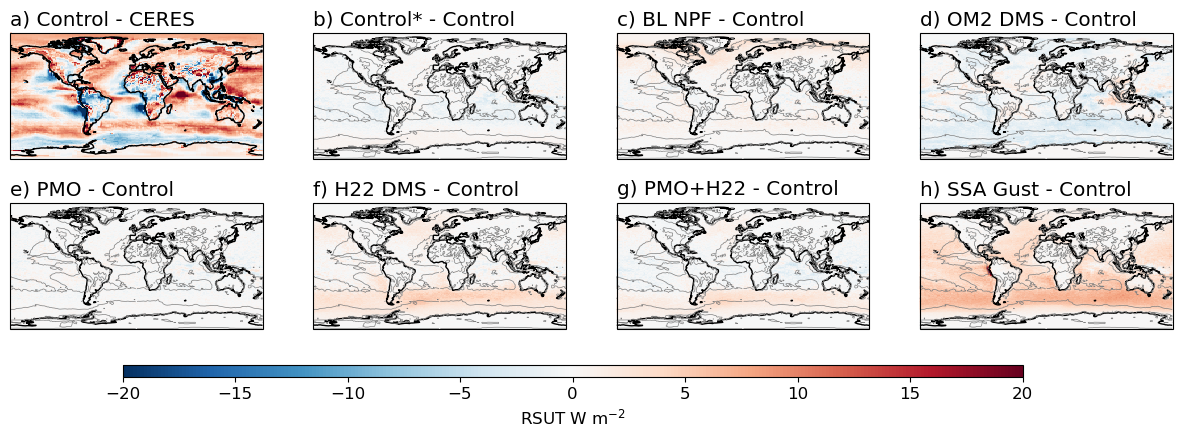

In [45]:
fig = plt.figure(figsize=(15,4))
p1 = plot_biases(data_ann.sel(run='Control').rsut-obsann.SWtoa,'a) Control - CERES',241,-20,20,
                     )
p = plot_biases((data_ann.sel(run='Control*').rsut-data_ann.sel(run='Control').rsut),'b) Control* - Control',242,-20,20,
                     plot_cont=(data_ann.sel(run='Control').rsut-obsann.SWtoa))
p = plot_biases((data_ann.sel(run='BL NPF').rsut-data_ann.sel(run='Control').rsut),'c) BL NPF - Control',243,-20,20,
                     plot_cont=(data_ann.sel(run='Control').rsut-obsann.SWtoa))
p = plot_biases((data_ann.sel(run='OM2').rsut-data_ann.sel(run='Control').rsut),'d) OM2 DMS - Control',244,-20,20,
                     plot_cont=(data_ann.sel(run='Control').rsut-obsann.SWtoa))
p = plot_biases((data_ann.sel(run='PMO').rsut-data_ann.sel(run='Control').rsut),'e) PMO - Control',245,-20,20,
                     plot_cont=(data_ann.sel(run='Control').rsut-obsann.SWtoa))
p = plot_biases((data_ann.sel(run='H22').rsut-data_ann.sel(run='Control').rsut),'f) H22 DMS - Control',246,-20,20,
                     plot_cont=(data_ann.sel(run='Control').rsut-obsann.SWtoa))
p = plot_biases((data_ann.sel(run='PMO+H22').rsut-data_ann.sel(run='Control').rsut),'g) PMO+H22 - Control',247,-20,20,
                     plot_cont=(data_ann.sel(run='Control').rsut-obsann.SWtoa))
p = plot_biases((data_ann.sel(run='SSA Gust').rsut-data_ann.sel(run='Control').rsut),'h) SSA Gust - Control',248,-20,20,
                     plot_cont=(data_ann.sel(run='Control').rsut-obsann.SWtoa))

cax = plt.axes([0.2, 0.0, 0.6, 0.03])
plt.colorbar(p1,cax=cax,orientation='horizontal',label='RSUT W m$^{-2}$');


plt.subplots_adjust(bottom=0.1)
plt.savefig(fig_dir+'/figures/change_in_rsut.pdf',bbox_inches='tight')

# Figure 7 Annual LWP changes

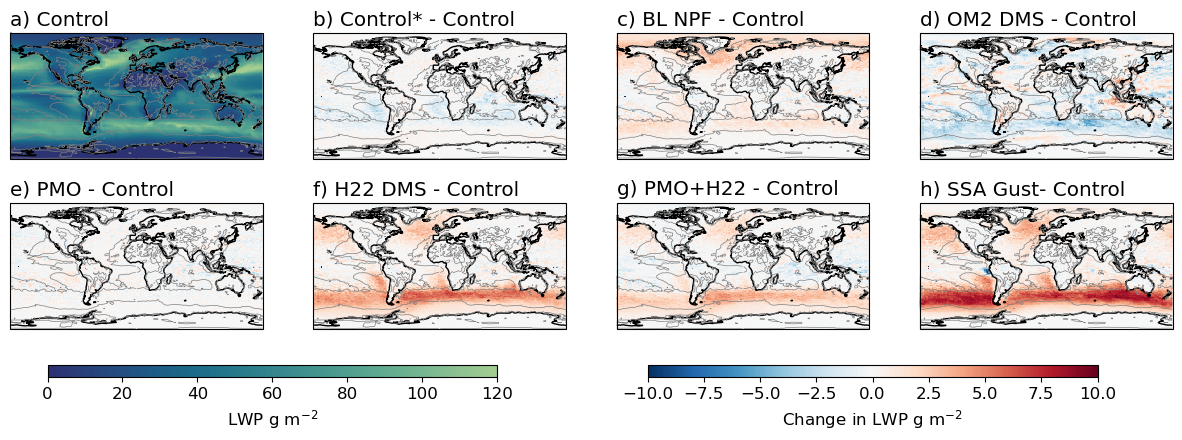

In [46]:
fig = plt.figure(figsize=(15,4))
p1 = plot_biases(data_ann.sel(run='Control').lwp*1000,'a) Control',241,0,120,cmap=sns.color_palette("crest_r", as_cmap=True),
                     plot_cont=(data_ann.sel(run='Control').rsut-obsann.SWtoa))
p = plot_biases((data_ann.sel(run='Control*').lwp-data_ann.sel(run='Control').lwp)*1000,'b) Control* - Control',242,-10,10,
                     plot_cont=(data_ann.sel(run='Control').rsut-obsann.SWtoa))
p = plot_biases((data_ann.sel(run='BL NPF').lwp-data_ann.sel(run='Control').lwp)*1000,'c) BL NPF - Control',243,-10,10,
                     plot_cont=(data_ann.sel(run='Control').rsut-obsann.SWtoa))
p = plot_biases((data_ann.sel(run='OM2').lwp-data_ann.sel(run='Control').lwp)*1000,'d) OM2 DMS - Control',244,-10,10,
                     plot_cont=(data_ann.sel(run='Control').rsut-obsann.SWtoa))
p = plot_biases((data_ann.sel(run='PMO').lwp-data_ann.sel(run='Control').lwp)*1000,'e) PMO - Control',245,-10,10,
                     plot_cont=(data_ann.sel(run='Control').rsut-obsann.SWtoa))
p = plot_biases((data_ann.sel(run='H22').lwp-data_ann.sel(run='Control').lwp)*1000,'f) H22 DMS - Control',246,-10,10,
                     plot_cont=(data_ann.sel(run='Control').rsut-obsann.SWtoa))
p = plot_biases((data_ann.sel(run='PMO+H22').lwp-data_ann.sel(run='Control').lwp)*1000,'g) PMO+H22 - Control',247,-10,10,
                     plot_cont=(data_ann.sel(run='Control').rsut-obsann.SWtoa))
p = plot_biases((data_ann.sel(run='SSA Gust').lwp-data_ann.sel(run='Control').lwp)*1000,'h) SSA Gust- Control',248,-10,10,
                     plot_cont=(data_ann.sel(run='Control').rsut-obsann.SWtoa))

cax = plt.axes([0.15, 0.0, 0.3, 0.03])
plt.colorbar(p1,cax=cax,orientation='horizontal',label='LWP g m$^{-2}$');

cax = plt.axes([0.55, 0.0, 0.3, 0.03])
plt.colorbar(p,cax=cax,orientation='horizontal',label='Change in LWP g m$^{-2}$');

plt.subplots_adjust(bottom=0.1)
plt.savefig(fig_dir+'/figures/change_in_lwp.pdf',bbox_inches='tight')

# Figure 8 RSUT seasonal changes PMO+H22

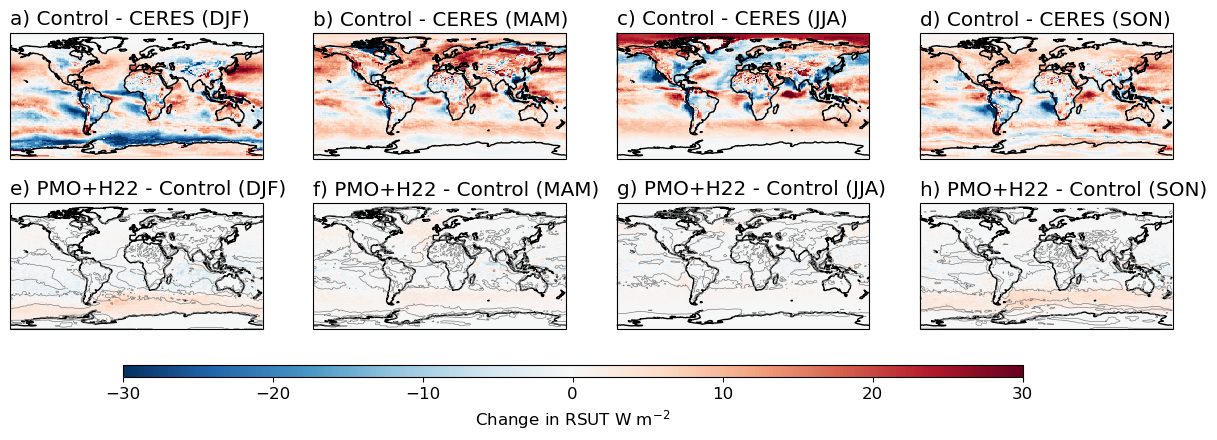

In [47]:
fig = plt.figure(figsize=(15,4))

for i,sea in enumerate(['DJF','MAM','JJA','SON']):
    alpha = ['a','b','c','d']
    p1 = plot_biases(data_sea.sel(run='Control',season=sea).rsut-obssea.SWtoa.sel(season=sea),
                    '{}) Control - CERES ({})'.format(alpha[i],sea),[2,4,1+i],-30,30,)
    alpha = ['e','f','g','h']
    p = plot_biases((data_sea.sel(run='PMO+H22',season=sea).rsut-data_sea.sel(run='Control',season=sea).rsut),
                    '{}) PMO+H22 - Control ({})'.format(alpha[i],sea),[2,4,5+i],-30,30,
                     plot_cont=data_sea.sel(run='Control',season=sea).rsut-obssea.SWtoa.sel(season=sea))

cax = plt.axes([0.2, 0.0, 0.6, 0.03])
plt.colorbar(p,cax=cax,orientation='horizontal',label='Change in RSUT W m$^{-2}$');

plt.subplots_adjust(bottom=0.1)
plt.savefig(fig_dir+'/figures/change_in_rsut_sea_best.pdf',bbox_inches='tight')

### Some stats

In [48]:
dfrsutann = pd.DataFrame(columns=['Global','SO (43-69S)','Sub-polar (43-58S)','Polar (58-69S)'],index=run[:-1])
l = [1,2,0,4,5,3,6,7]
dfrsutann['Global'] = (data_ann['rsut']-obsann['SWtoa']).mean(['lat','lon']).values[l]
dfrsutann['SO (43-69S)'] = (data_ann['rsut']-obsann['SWtoa']).sel(lat=slice(-69,-43)).mean(['lat','lon']).values[l]
dfrsutann['Sub-polar (43-58S)'] = (data_ann['rsut']-obsann['SWtoa']).sel(lat=slice(-58,-43)).mean(['lat','lon']).values[l]
dfrsutann['Polar (58-69S)'] = (data_ann['rsut']-obsann['SWtoa']).sel(lat=slice(-69,-58)).mean(['lat','lon']).values[l]
dfrsutann = dfrsutann.astype(float).round(2)

dfrsutsea = pd.DataFrame(columns=['Global','SO (43-69S)','Sub-polar (43-58S)','Polar (58-69S)'],index=run[:-1])
dfrsutsea['Global'] = (data_sea['rsut']-obssea['SWtoa']).sel(season='DJF').mean(['lat','lon']).values[l]
dfrsutsea['SO (43-69S)'] = (data_sea['rsut']-obssea['SWtoa']).sel(season='DJF').sel(lat=slice(-69,-43)).mean(['lat','lon']).values[l]
dfrsutsea['Sub-polar (43-58S)'] = (data_sea['rsut']-obssea['SWtoa']).sel(season='DJF').sel(lat=slice(-58,-43)).mean(['lat','lon']).values[l]
dfrsutsea['Polar (58-69S)'] = (data_sea['rsut']-obssea['SWtoa']).sel(season='DJF').sel(lat=slice(-69,-58)).mean(['lat','lon']).values[l]
dfrsutsea = dfrsutsea.astype(float).round(2)

dfrsut = pd.concat([dfrsutann, dfrsutsea], axis=1, keys=['Annual', 'DJF'])

In [49]:
dfrsut

Annual                                                  DJF  \
         Global SO (43-69S) Sub-polar (43-58S) Polar (58-69S) Global   
Control    2.40        1.63               5.43          -3.43   0.18   
Control*   2.32        1.87               5.49          -2.95   0.24   
BL NPF     2.89        1.94               5.87          -3.30   0.31   
OM2        1.85       -0.09               3.64          -5.06  -0.98   
PMO        2.37        1.70               5.44          -3.28  -0.03   
H22        3.19        4.19               8.58          -1.65   1.33   
PMO+H22    2.60        3.28               7.38          -2.18   0.40   
SSA Gust   4.65        6.23              11.54          -0.85   2.69   

                                                        
         SO (43-69S) Sub-polar (43-58S) Polar (58-69S)  
Control        -6.26               2.37         -17.78  
Control*       -5.03               3.07         -15.84  
BL NPF         -5.76               3.01         -17.45  
OM2           -10.93              -2.79         -21.78  
PMO            -6.54               1.76         -17.62  
H22            -1.07               7.93         -13.06  
PMO+H22        -3.41               5.08         -14.72  
SSA Gust        1.12              11.18         -12.28

In [50]:
dflwpann = pd.DataFrame(columns=['Global','SO (43-69S)','Sub-polar (43-58S)','Polar (58-69S)'],index=run[:-1])
l = [1,2,0,4,5,3,6,7]
dflwpann['Global'] = (data_ann['lwp']-data_ann['lwp'].sel(run='Control')).mean(['lat','lon']).values[l]
dflwpann['SO (43-69S)'] = (data_ann['lwp']-data_ann['lwp'].sel(run='Control')).sel(lat=slice(-69,-43)).mean(['lat','lon']).values[l]
dflwpann['Sub-polar (43-58S)'] = (data_ann['lwp']-data_ann['lwp'].sel(run='Control')).sel(lat=slice(-58,-43)).mean(['lat','lon']).values[l]
dflwpann['Polar (58-69S)'] = (data_ann['lwp']-data_ann['lwp'].sel(run='Control')).sel(lat=slice(-69,-58)).mean(['lat','lon']).values[l]

dflwpann['Global'].loc['Control'] = (data_ann['lwp'].sel(run='Control')).mean(['lat','lon']).values
dflwpann['SO (43-69S)'].loc['Control'] = (data_ann['lwp'].sel(run='Control')).sel(lat=slice(-69,-43)).mean(['lat','lon']).values
dflwpann['Sub-polar (43-58S)'].loc['Control'] = (data_ann['lwp'].sel(run='Control')).sel(lat=slice(-58,-43)).mean(['lat','lon']).values
dflwpann['Polar (58-69S)'].loc['Control'] = (data_ann['lwp'].sel(run='Control')).sel(lat=slice(-69,-58)).mean(['lat','lon']).values

dflwpann = (dflwpann*1000).astype(float).round(2)

dflwpsea = pd.DataFrame(columns=['Global','SO (43-69S)','Sub-polar (43-58S)','Polar (58-69S)'],index=run[:-1])
dflwpsea['Global'] = (data_sea['lwp']-data_sea['lwp'].sel(run='Control')).sel(season='DJF').mean(['lat','lon']).values[l]
dflwpsea['SO (43-69S)'] = (data_sea['lwp']-data_sea['lwp'].sel(run='Control')).sel(season='DJF').sel(lat=slice(-69,-43)).mean(['lat','lon']).values[l]
dflwpsea['Sub-polar (43-58S)'] = (data_sea['lwp']-data_sea['lwp'].sel(run='Control')).sel(season='DJF').sel(lat=slice(-58,-43)).mean(['lat','lon']).values[l]
dflwpsea['Polar (58-69S)'] = (data_sea['lwp']-data_sea['lwp'].sel(run='Control')).sel(season='DJF').sel(lat=slice(-69,-58)).mean(['lat','lon']).values[l]

dflwpsea['Global'].loc['Control'] = (data_sea['lwp'].sel(run='Control')).sel(season='DJF').mean(['lat','lon']).values
dflwpsea['SO (43-69S)'].loc['Control'] = (data_sea['lwp'].sel(run='Control')).sel(season='DJF').sel(lat=slice(-69,-43)).mean(['lat','lon']).values
dflwpsea['Sub-polar (43-58S)'].loc['Control'] = (data_sea['lwp'].sel(run='Control')).sel(season='DJF').sel(lat=slice(-58,-43)).mean(['lat','lon']).values
dflwpsea['Polar (58-69S)'].loc['Control'] = (data_sea['lwp'].sel(run='Control')).sel(season='DJF').sel(lat=slice(-69,-58)).mean(['lat','lon']).values

dflwpsea = (dflwpsea*1000).astype(float).round(2)

dflwp = pd.concat([dflwpann, dflwpsea], axis=1, keys=['Annual', 'DJF'])

In [51]:
dflwp
# Note Control shows actual mean - experiments show change from control 

Annual                                                  DJF  \
         Global SO (43-69S) Sub-polar (43-58S) Polar (58-69S) Global   
Control   42.96       60.35              78.46          36.21  40.55   
Control*  -0.11        0.09              -0.01           0.23   0.03   
BL NPF     0.54        0.46               0.68           0.16   0.14   
OM2       -0.42       -0.96              -1.54          -0.20  -0.75   
PMO       -0.00        0.06               0.04           0.09  -0.16   
H22        0.92        2.62               3.53           1.40   0.98   
PMO+H22    0.42        1.80               2.35           1.07   0.36   
SSA Gust   1.31        4.09               5.75           1.87   1.02   

                                                        
         SO (43-69S) Sub-polar (43-58S) Polar (58-69S)  
Control        65.14              82.71          41.70  
Control*        0.65               0.43           0.94  
BL NPF          0.45               0.60           0.24  
OM2            -3.00              -3.90          -1.79  
PMO            -0.27              -0.53           0.08  
H22             3.69               4.47           2.66  
PMO+H22         2.18               2.37           1.93  
SSA Gust        3.69               4.67           2.38